# Beyond *"You May Also Like"*: Deconstructing Consumer Choices with Data Science

This Data Science project presents a data-driven approach to understand consumer behavior and personalize product recommendations using an e-commerce dataset. It holds the potential to boost sales significantly and enhance customer experience. The project is structured around three key chapters: Exploratory Data Analysis, Market Basket Analysis, and Recommendation System.

The first one, the EDA, is a crucial step for uncovering hidden patterns on purchases like consumer behavior, product preferences, basket size and average prices over time.

The EDA paves the way for the *association rule mining approach* that is used in a **Market Basket Analysis** with the `apriori` library in Python. More than only using the library, key terms like **antecedents**, **consequents**, **support**, **confidence**, and **lift** are also explained.

Further, a **recommendation system** based on customer similarity is developed to generate recommendations of products. Thus, as the customers browses through the site, their experience is personalized in order to predict what *"they might also like"* and to maximize the sales for the company as well.

## 0. Imports

### 0.1. Libraries

In [1]:
### Data manipulation 
import pandas                   as pd
import numpy                    as np

### Data visualization
import seaborn                  as sns
import matplotlib               as mpl
import matplotlib.pyplot        as plt

### Recommendation system
from sklearn.metrics.pairwise   import cosine_similarity

### Market Basket
from mlxtend.frequent_patterns  import apriori, association_rules

### Other libraries
import datetime 
import inflection
import warnings

### 0.2. Settings

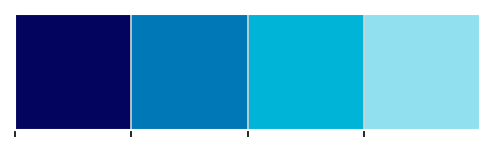

In [2]:
### Ignoring warnings
warnings.filterwarnings('ignore')

### Pandas Settings
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

### Visualization Settings
%matplotlib inline

mpl.style.use('ggplot')

mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['figure.titlesize']    = 25
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['font.size']           = 12
mpl.rcParams['axes.grid']           = True
mpl.rcParams['figure.dpi']          = 150

### Palette Seting
customer_behavior = ['#03045e', '#0077b6', '#00b4d8', '#90e0ef']
sns.set_palette(sns.color_palette(customer_behavior))
sns.palplot(sns.color_palette(customer_behavior))

### 0.3. Functions

In [3]:
def df_shape(df):
    """
    Summary: The function prints the number of rows and columns of a given DataFrame.

    Args:
        df: the DataFrame we want to know more about.
    
    Returns: a text indicating the number of rows and columns of the DataFrame.
    """

    print('Number of rows: {:,}'.format(df.shape[0]))
    print('Number of columns: {:,}'.format(df.shape[1]))

    return None

def set_image(fig, title, xlabel, ylabel, xrotation=0, yrotation=0):
    """
    Summary: This function sets the image configuration.

    Args:
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
        rotation: the rotation of the labels. default as 0.

    Returns: None
    """

    plt.title(title)
    plt.xlabel(xlabel, color='black')
    plt.ylabel(ylabel, color='black')
    plt.xticks(rotation=xrotation)
    plt.yticks(rotation=yrotation)
    plt.tick_params(left=False, bottom=False);

    return fig

### Preprocessing

def renaming_columns(df):
    """
    Summary: This function transforms the column names to snake_case style.

    Args: Dataframe with incorrect column names.

    Returns: list of updated column names.
    """

    # List of columns
    old_columns = df.columns.tolist()
    # Lambda function
    snake_case = lambda x: inflection.underscore(x)
    # Apply the function to each column 
    new_columns = list(map(snake_case, old_columns))
    # Assigning new column names to DataFrame
    df.columns = new_columns

    # Some columns need to be renamed manually
    mapping = {'itemname': 'item_name'}

    # Rename the columns
    df.rename(columns=mapping, inplace=True)

    # Display the updated column names
    
    return df.columns.tolist()

def null_values(df):
    """
    Summary: This function returns a DataFrame with the number of null values and the percentage of null values

    Args: Dataframe with null values to explore

    Returns: Dataframe with the number of null values and the percentage of them
    """

    df_null_values = pd.DataFrame(
        {'NA': df.isna().sum(), 
        '%NA': (df.isna().sum()) / (df.shape[0]) * (100)}
        ).sort_values('NA', ascending=False)
    
    return df_null_values

def df_filter(df, columns, cutoff):
    """
    Summary: This function filters a DataFrame based on a given list of columns and a given cutoff value

    Args: 
        df: the DataFrame we want to filter
        columns: the list of columns we want to filter
        cutoff: the cutoff value

    Returns: the filtered DataFrame
    """

    conditions = np.ones(len(df), dtype=bool)

    for column_name in columns:
        conditions &= (df[column_name] <= df[column_name].quantile(cutoff)) & (df[column_name] > 0)
    
    return df[conditions]

### 0.4. Data

In [4]:
# Data loading
df = pd.read_csv('../data/raw/market_basket.csv', sep=';')

# https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis

## 1. Data description

In [5]:
df.head(10)

BillNo                             Itemname  Quantity              Date  \
0  536365   WHITE HANGING HEART T-LIGHT HOLDER         6  01.12.2010 08:26   
1  536365                  WHITE METAL LANTERN         6  01.12.2010 08:26   
2  536365       CREAM CUPID HEARTS COAT HANGER         8  01.12.2010 08:26   
3  536365  KNITTED UNION FLAG HOT WATER BOTTLE         6  01.12.2010 08:26   
4  536365       RED WOOLLY HOTTIE WHITE HEART.         6  01.12.2010 08:26   
5  536365         SET 7 BABUSHKA NESTING BOXES         2  01.12.2010 08:26   
6  536365    GLASS STAR FROSTED T-LIGHT HOLDER         6  01.12.2010 08:26   
7  536366               HAND WARMER UNION JACK         6  01.12.2010 08:28   
8  536366            HAND WARMER RED POLKA DOT         6  01.12.2010 08:28   
9  536367        ASSORTED COLOUR BIRD ORNAMENT        32  01.12.2010 08:34   

  Price  CustomerID         Country  
0  2,55   17850.000  United Kingdom  
1  3,39   17850.000  United Kingdom  
2  2,75   17850.000  United Kingdom  
3  3,39   17850.000  United Kingdom  
4  3,39   17850.000  United Kingdom  
5  7,65   17850.000  United Kingdom  
6  4,25   17850.000  United Kingdom  
7  1,85   17850.000  United Kingdom  
8  1,85   17850.000  United Kingdom  
9  1,69   13047.000  United Kingdom

### 1.1. Data Dimensions

In [6]:
df_shape(df)

Number of rows: 522,064
Number of columns: 7


### 1.2. Columns

- **BillNo:** 6-digit number assigned to each transaction. Nominal.
- **Itemname:** Product name. Nominal.
- **Quantity:** The quantities of each product per transaction. Numeric.
- **Date:** The day and time when each transaction was generated. Numeric.
- **Price:** Product price. Numeric.
- **CustomerID:** 5-digit number assigned to each customer. Nominal.
- **Country:** Name of the country where each customer resides. Nominal.

### 1.3. Data Types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


Types:

- **BillNo:** Transform `object` into `integer`
- **Itemname:** `object` is correct
- **Quantity:** `integer` is correct
- **Date:** `object` into `datetime`
- **Price:** `object` into `float`
- **CustomerID:** `float` into `integer`
- **Country:** `object` is correct

Missing data:
- **Itemname** and **CustomerID** have missing data.

## 2. Preprocessing and Data Exploration

### 2.1. Renaming Columns

In [8]:
# Renaming dataset columns
renaming_columns(df)

['bill_no', 'item_name', 'quantity', 'date', 'price', 'customer_id', 'country']

### 2.2. Changing data types

In [9]:
# 'date' to datetime
df['timestamp'] = pd.to_datetime(df['date'])
# 'price' to float
df['price'] = df['price'].str.replace(',', '.').astype('float64')
# 'customer_id' to int
df['customer_id'] = pd.to_numeric(df['customer_id'], errors='coerce').astype('Int64')

In [10]:
# Adjusting 'bill_no' column where it contains letters before changing to int
df[df['bill_no'].str.contains('[A-Za-z]', na=False)]

bill_no        item_name  quantity              date      price  \
288772  A563185  Adjust bad debt         1  12.08.2011 14:50  11062.060   
288773  A563186  Adjust bad debt         1  12.08.2011 14:51 -11062.060   
288774  A563187  Adjust bad debt         1  12.08.2011 14:52 -11062.060   

        customer_id         country           timestamp  
288772         <NA>  United Kingdom 2011-12-08 14:50:00  
288773         <NA>  United Kingdom 2011-12-08 14:51:00  
288774         <NA>  United Kingdom 2011-12-08 14:52:00

In [11]:
# The problem is that 'item_name' column is set as 'Adjust bad debt', probably because of an error in billing
df.loc[df['item_name'] == 'Adjust bad debt', :]

bill_no        item_name  quantity              date      price  \
288772  A563185  Adjust bad debt         1  12.08.2011 14:50  11062.060   
288773  A563186  Adjust bad debt         1  12.08.2011 14:51 -11062.060   
288774  A563187  Adjust bad debt         1  12.08.2011 14:52 -11062.060   

        customer_id         country           timestamp  
288772         <NA>  United Kingdom 2011-12-08 14:50:00  
288773         <NA>  United Kingdom 2011-12-08 14:51:00  
288774         <NA>  United Kingdom 2011-12-08 14:52:00

In [12]:
# Considering that these three rows are the only ones with errors, we will drop them
df.drop([288772, 288773, 288774], axis=0, inplace=True)

# Now we can change the 'bill_no' column to int
df['bill_no'] = df['bill_no'].astype('int64')

### 2.3. Creating new features for data exploration

In [13]:
df['date']  = df['timestamp'].dt.date
df['day']   = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['year']  = df['timestamp'].dt.year

### 2.4. Checking for duplicates

In [14]:
df.duplicated().sum()

5286

In [15]:
df.drop_duplicates(keep='first', inplace=True)

### 2.5. Checking NaN

In [16]:
# Checking for null values
null_values(df)

NA    %NA
customer_id  133964 25.923
item_name      1455  0.282
bill_no           0  0.000
quantity          0  0.000
date              0  0.000
price             0  0.000
country           0  0.000
timestamp         0  0.000
day               0  0.000
month             0  0.000
year              0  0.000

### 2.6. Numerical attributes

In [17]:
# Numerical attributes
num_attributes = df.drop(['bill_no', 'item_name', 'date', 'country', 'customer_id', 'year'], axis=1)

# Describe
num_attributes.describe().T

count   mean     std       min    25%    50%    75%       max
quantity 516775.000 10.163 161.917 -9600.000  1.000  3.000 10.000 80995.000
price    516775.000  3.863  32.604     0.000  1.250  2.080  4.130 13541.330
day      516775.000 15.667   8.122     1.000 10.000 15.000 22.000    31.000
month    516775.000  6.915   3.365     1.000  4.000  7.000 10.000    12.000

- **Quantity:** negative values will be considered as errors
- **Price:** price as zero will be considered as errors

#### 2.6.1. Exploring `quantity` values

In [18]:
df.loc[df['quantity'] > 5000, :]

bill_no                       item_name  quantity        date  price  \
59999    541431  MEDIUM CERAMIC TOP STORAGE JAR     74215  2011-01-18  1.040   
72509    542504                             NaN      5568  2011-01-28  0.000   
483371   578841  ASSTD DESIGN 3D PAPER STICKERS     12540  2011-11-25  0.000   
520583   581483     PAPER CRAFT , LITTLE BIRDIE     80995  2011-09-12  2.080   

        customer_id         country           timestamp  day  month  year  
59999         12346  United Kingdom 2011-01-18 10:01:00   18      1  2011  
72509          <NA>  United Kingdom 2011-01-28 12:03:00   28      1  2011  
483371        13256  United Kingdom 2011-11-25 15:57:00   25     11  2011  
520583        16446  United Kingdom 2011-09-12 09:15:00   12      9  2011

In [19]:
df.loc[df['quantity'] < 0, :]

bill_no item_name  quantity        date  price  customer_id  \
2359     536589       NaN       -10  2010-01-12  0.000         <NA>   
4289     536764       NaN       -38  2010-02-12  0.000         <NA>   
6998     536996       NaN       -20  2010-03-12  0.000         <NA>   
6999     536997       NaN       -20  2010-03-12  0.000         <NA>   
7000     536998       NaN        -6  2010-03-12  0.000         <NA>   
...         ...       ...       ...         ...    ...          ...   
515634   581210     check       -26  2011-07-12  0.000         <NA>   
515636   581212      lost     -1050  2011-07-12  0.000         <NA>   
515637   581213     check       -30  2011-07-12  0.000         <NA>   
517209   581226   missing      -338  2011-08-12  0.000         <NA>   
519172   581422   smashed      -235  2011-08-12  0.000         <NA>   

               country           timestamp  day  month  year  
2359    United Kingdom 2010-01-12 16:50:00   12      1  2010  
4289    United Kingdom 2010-02-12 14:42:00   12      2  2010  
6998    United Kingdom 2010-03-12 15:30:00   12      3  2010  
6999    United Kingdom 2010-03-12 15:30:00   12      3  2010  
7000    United Kingdom 2010-03-12 15:30:00   12      3  2010  
...                ...                 ...  ...    ...   ...  
515634  United Kingdom 2011-07-12 18:36:00   12      7  2011  
515636  United Kingdom 2011-07-12 18:38:00   12      7  2011  
515637  United Kingdom 2011-07-12 18:38:00   12      7  2011  
517209  United Kingdom 2011-08-12 09:56:00   12      8  2011  
519172  United Kingdom 2011-08-12 15:24:00   12      8  2011  

[1336 rows x 11 columns]

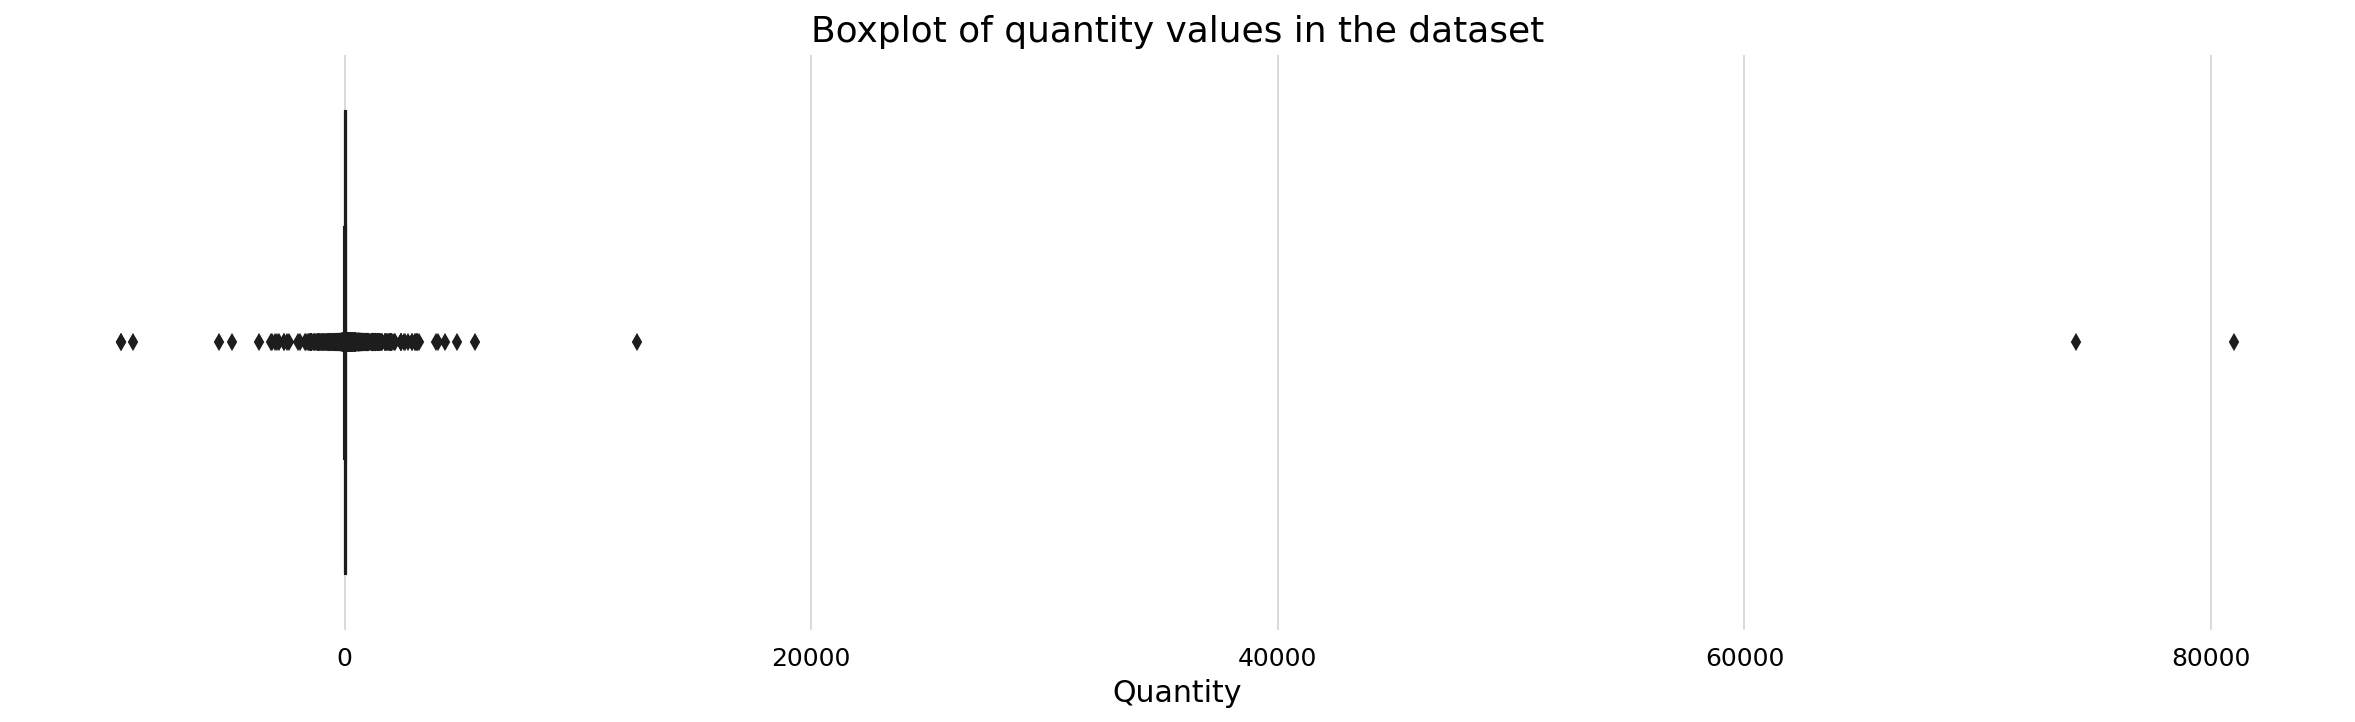

In [20]:
# Boxplot
fig = sns.boxplot(data=df, x='quantity')

# Customizing
fig = set_image(fig, 'Boxplot of quantity values in the dataset', 'Quantity', None)

#### 2.6.2. Exploring `price` values

In [21]:
df.loc[df['price'] == 0, :]

bill_no                     item_name  quantity        date  price  \
613      536414                           NaN        56  2010-01-12  0.000   
1937     536545                           NaN         1  2010-01-12  0.000   
1938     536546                           NaN         1  2010-01-12  0.000   
1939     536547                           NaN         1  2010-01-12  0.000   
1940     536549                           NaN         1  2010-01-12  0.000   
...         ...                           ...       ...         ...    ...   
517266   581234                           NaN        27  2011-08-12  0.000   
518770   581406  POLYESTER FILLER PAD 45x45cm       240  2011-08-12  0.000   
518771   581406  POLYESTER FILLER PAD 40x40cm       300  2011-08-12  0.000   
518820   581408                           NaN        20  2011-08-12  0.000   
519172   581422                       smashed      -235  2011-08-12  0.000   

        customer_id         country           timestamp  day  month  year  
613            <NA>  United Kingdom 2010-01-12 11:52:00   12      1  2010  
1937           <NA>  United Kingdom 2010-01-12 14:32:00   12      1  2010  
1938           <NA>  United Kingdom 2010-01-12 14:33:00   12      1  2010  
1939           <NA>  United Kingdom 2010-01-12 14:33:00   12      1  2010  
1940           <NA>  United Kingdom 2010-01-12 14:34:00   12      1  2010  
...             ...             ...                 ...  ...    ...   ...  
517266         <NA>  United Kingdom 2011-08-12 10:33:00   12      8  2011  
518770         <NA>  United Kingdom 2011-08-12 13:58:00   12      8  2011  
518771         <NA>  United Kingdom 2011-08-12 13:58:00   12      8  2011  
518820         <NA>  United Kingdom 2011-08-12 14:06:00   12      8  2011  
519172         <NA>  United Kingdom 2011-08-12 15:24:00   12      8  2011  

[2506 rows x 11 columns]

In [22]:
df.loc[df['price'] > 4500, :]

bill_no       item_name  quantity        date     price  customer_id  \
14696    537632      AMAZON FEE         1  2010-07-12 13541.330         <NA>   
167329   551697         POSTAGE         1  2011-03-05  8142.750        16029   
286674   562955  DOTCOM POSTAGE         1  2011-11-08  4505.170         <NA>   

               country           timestamp  day  month  year  
14696   United Kingdom 2010-07-12 15:08:00   12      7  2010  
167329  United Kingdom 2011-03-05 13:46:00    5      3  2011  
286674  United Kingdom 2011-11-08 10:14:00    8     11  2011

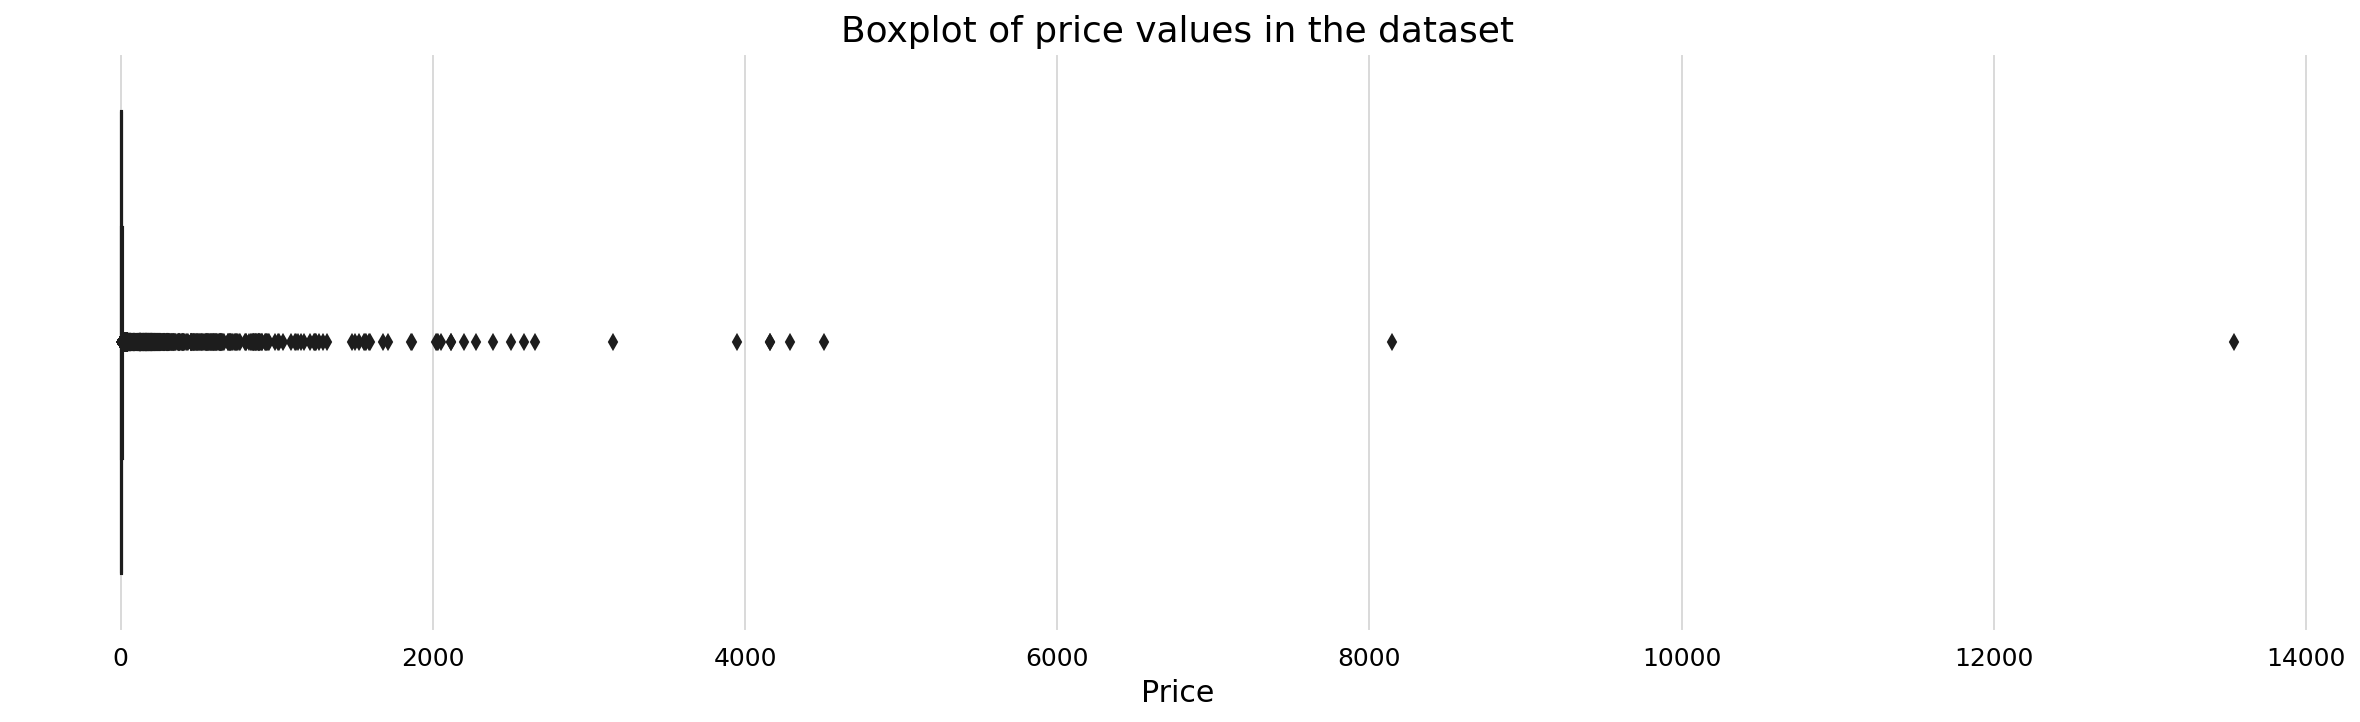

In [23]:
# Boxplot
fig = sns.boxplot(data=df, x='price')

# Customizing
fig = set_image(fig, 'Boxplot of price values in the dataset', 'Price', None)

### 2.7. Categorical attributes

In [24]:
# Categorical attributes
cat_attributes = df.select_dtypes(include=['object'])

# Values
cat_attributes.apply(lambda x: x.unique().shape[0])

item_name    4185
date          305
country        30
dtype: int64

### 2.8. Corrections

In [25]:
# Columns to filter
columns = ['quantity', 'price']

# According to the 'df_filter' function, we will drop the top 1% values of the specified columns and keep only the values that are higher than zero
df1 = df_filter(df, columns, 0.99)

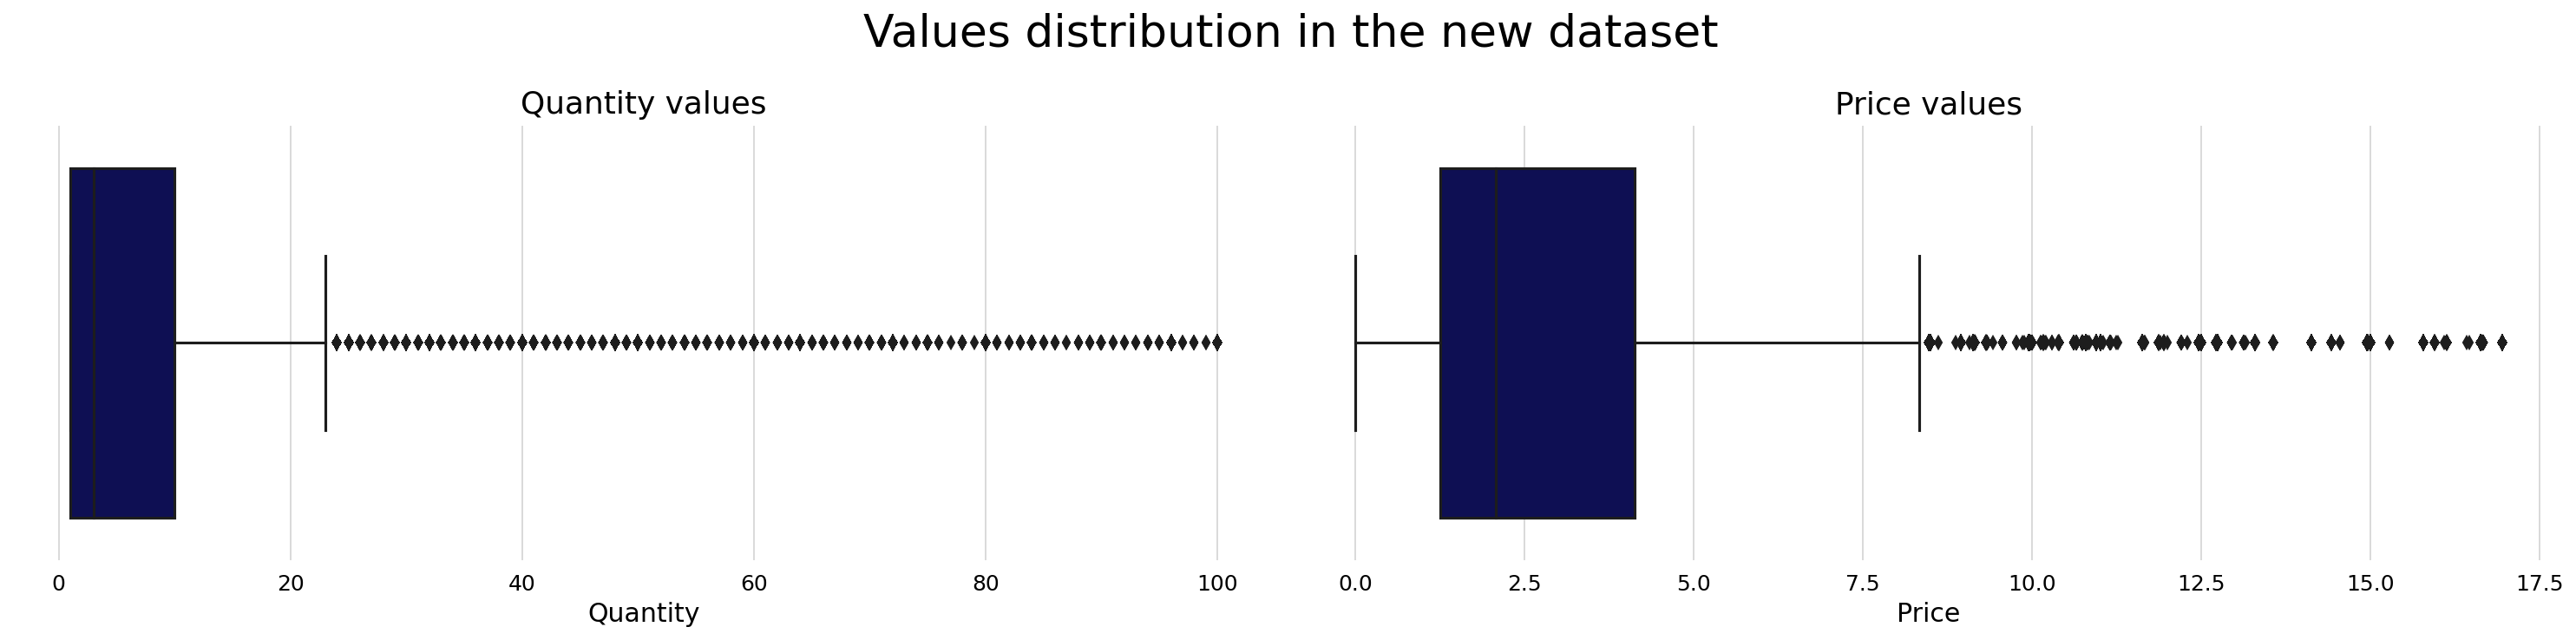

In [26]:
# Creating Figure
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Plot 1
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(data=df1, x='quantity')
ax1 = set_image(ax1, 'Quantity values', 'Quantity', None)

# Plot 2
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(data=df1, x='price')
ax2 = set_image(ax2, 'Price values', 'Price', None)

# Main title
fig.suptitle('Values distribution in the new dataset')

# Adjust spacing
plt.tight_layout()

## 3. Exploratory Data Analysis

### 3.1. How is the distribution of purchases per day in the dataset?

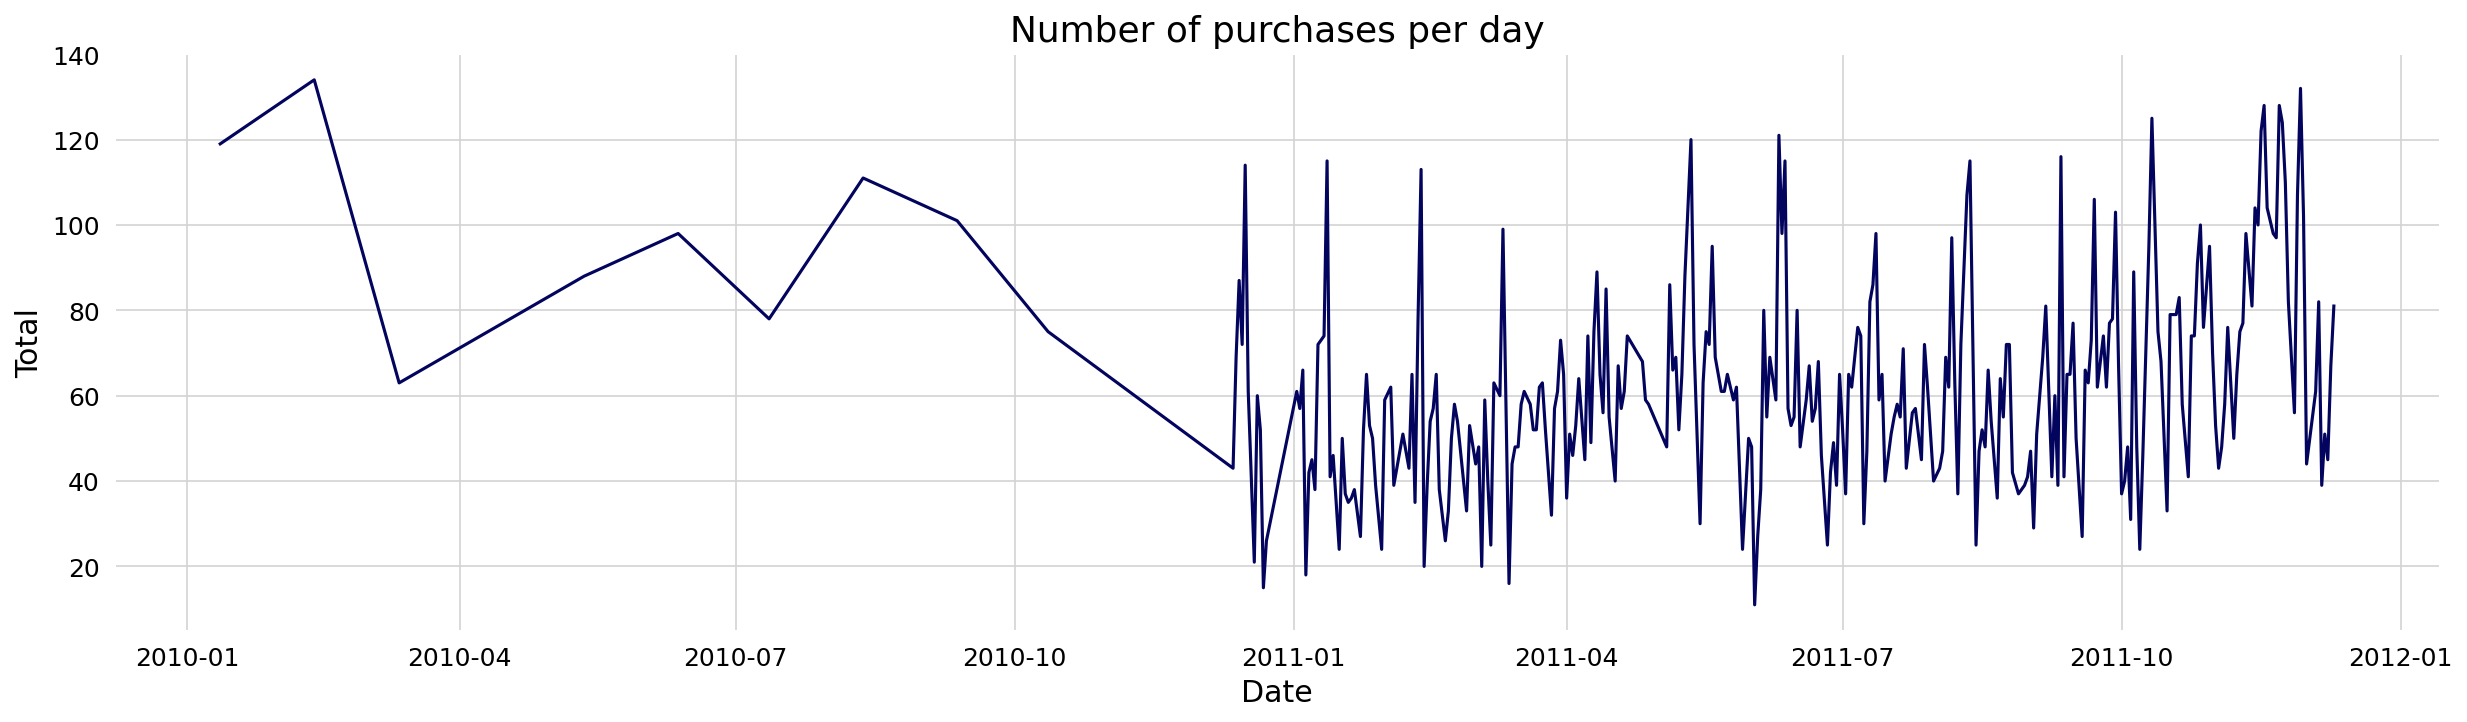

In [27]:
# Data manipulation
df_aux = df1.groupby(['date'])['bill_no'].nunique().reset_index()

# Creating Figure
fig = sns.lineplot(data=df_aux, x='date', y='bill_no')

# Customizing
fig = set_image(fig, 'Number of purchases per day', 'Date', 'Total')

- The number of purchases in 2010 is lower than in 2011
- The number of purchases oscillates a lot in 2011

### 3.2. How is the distribution of purchases in 2011?

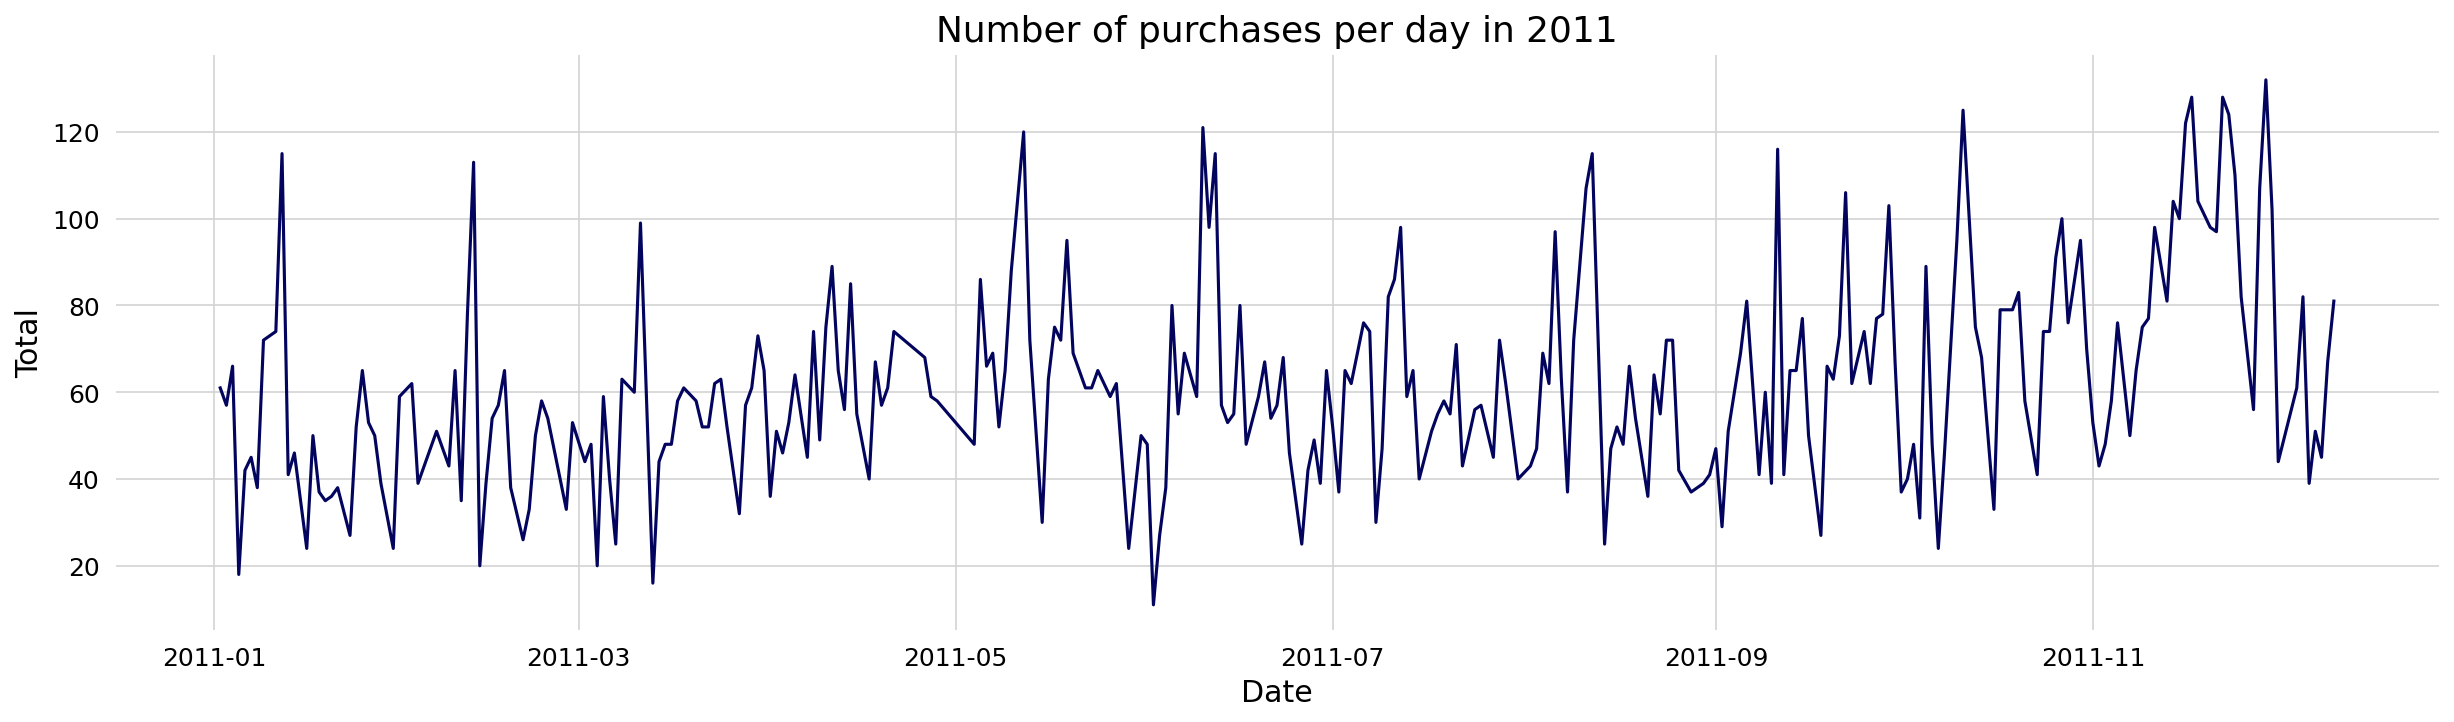

In [28]:
# Data manipulation
df_aux = df1.loc[df1['year'] == 2011, :] # Selecting only 2011 data
df_aux = df_aux.groupby('date')['bill_no'].nunique().reset_index() # Grouping by date

# Creating Figure
fig = sns.lineplot(data=df_aux, x='date', y='bill_no')

# Customizing
fig = set_image(fig, 'Number of purchases per day in 2011', 'Date', 'Total')

- The data is more well behaved in 2011 than in 2010, but the variations are very strong 
- There are a little bit more than 10 spikes in purchases of 2011

### 3.3. How is the distribution of purchases per month in 2011?

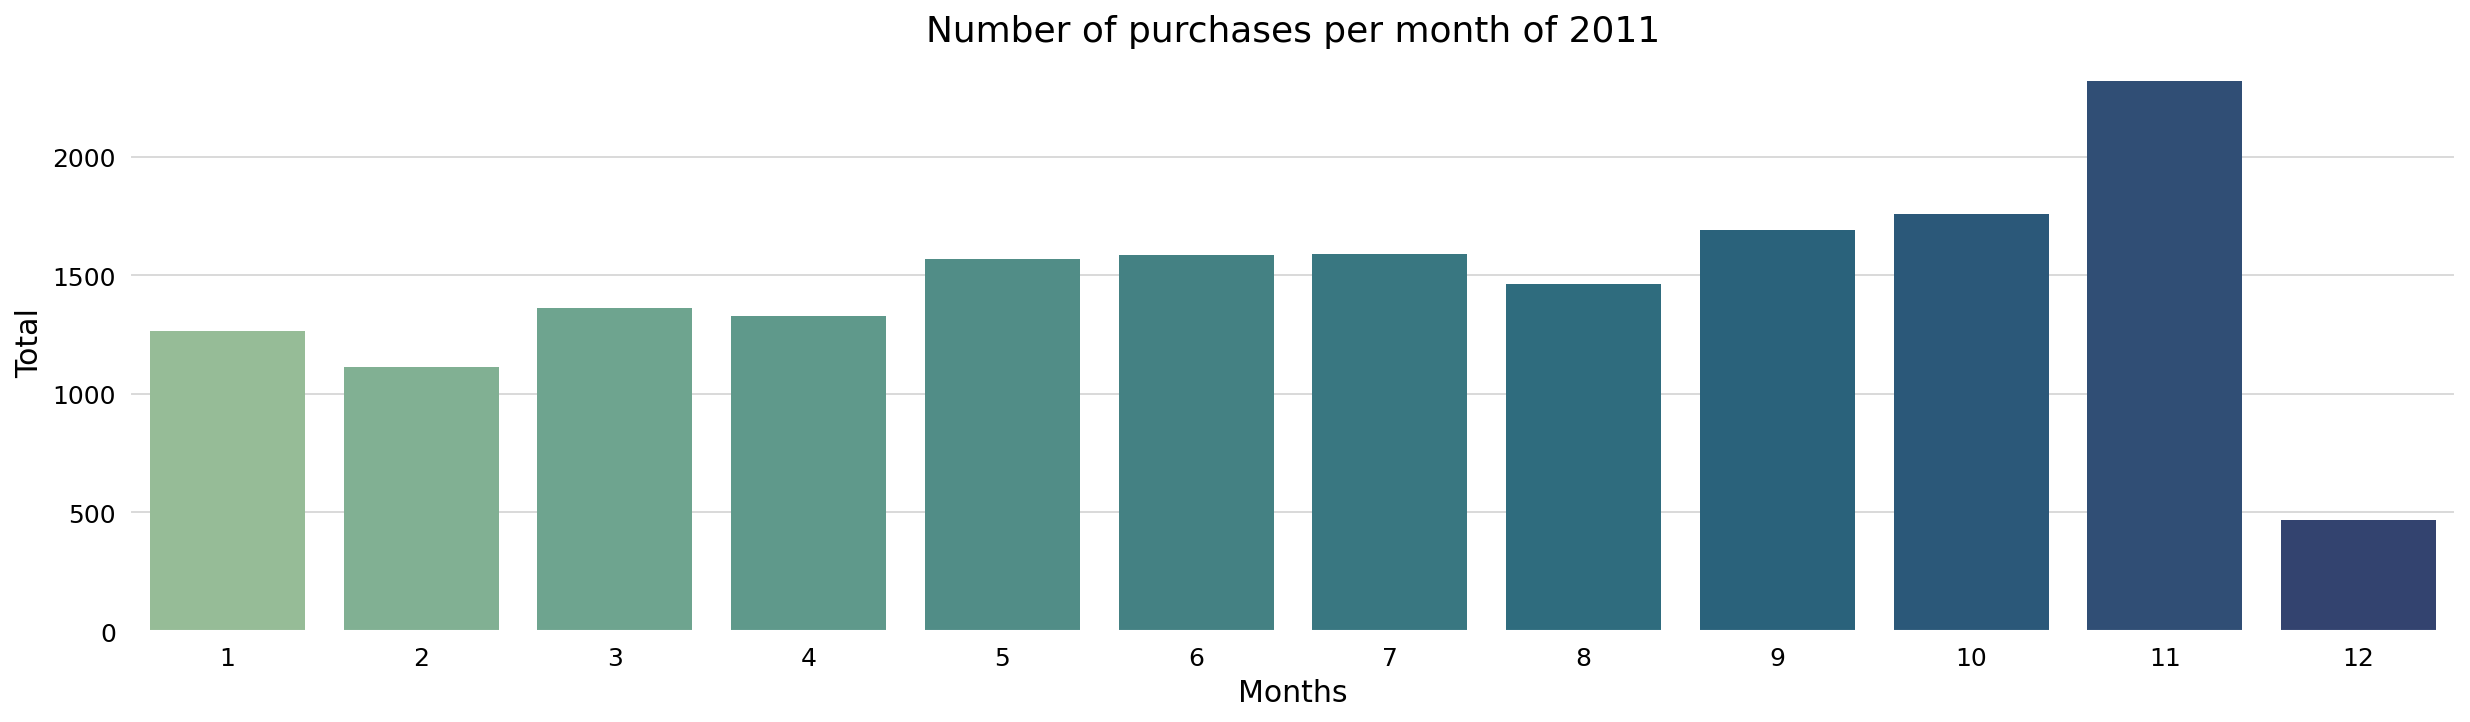

In [29]:
# Data manipulation
df_aux = df1.loc[df1['year'] == 2011, :] # Selecting only 2011 data
df_aux = df_aux.groupby(['month'])['bill_no'].nunique().reset_index() 

# Creating Figure
fig = sns.barplot(data=df_aux, x='month', y='bill_no', palette='crest')

# Customizing
fig = set_image(fig, 'Number of purchases per month of 2011', 'Months', 'Total')

- November is the highest selling month of 2011
- January and February have the lowest number of purchases
- The number of purchases increases throughout the year
- December have the lowest number of purchases due to lack of data

### 3.4. Do people spend more in the first half of the month?

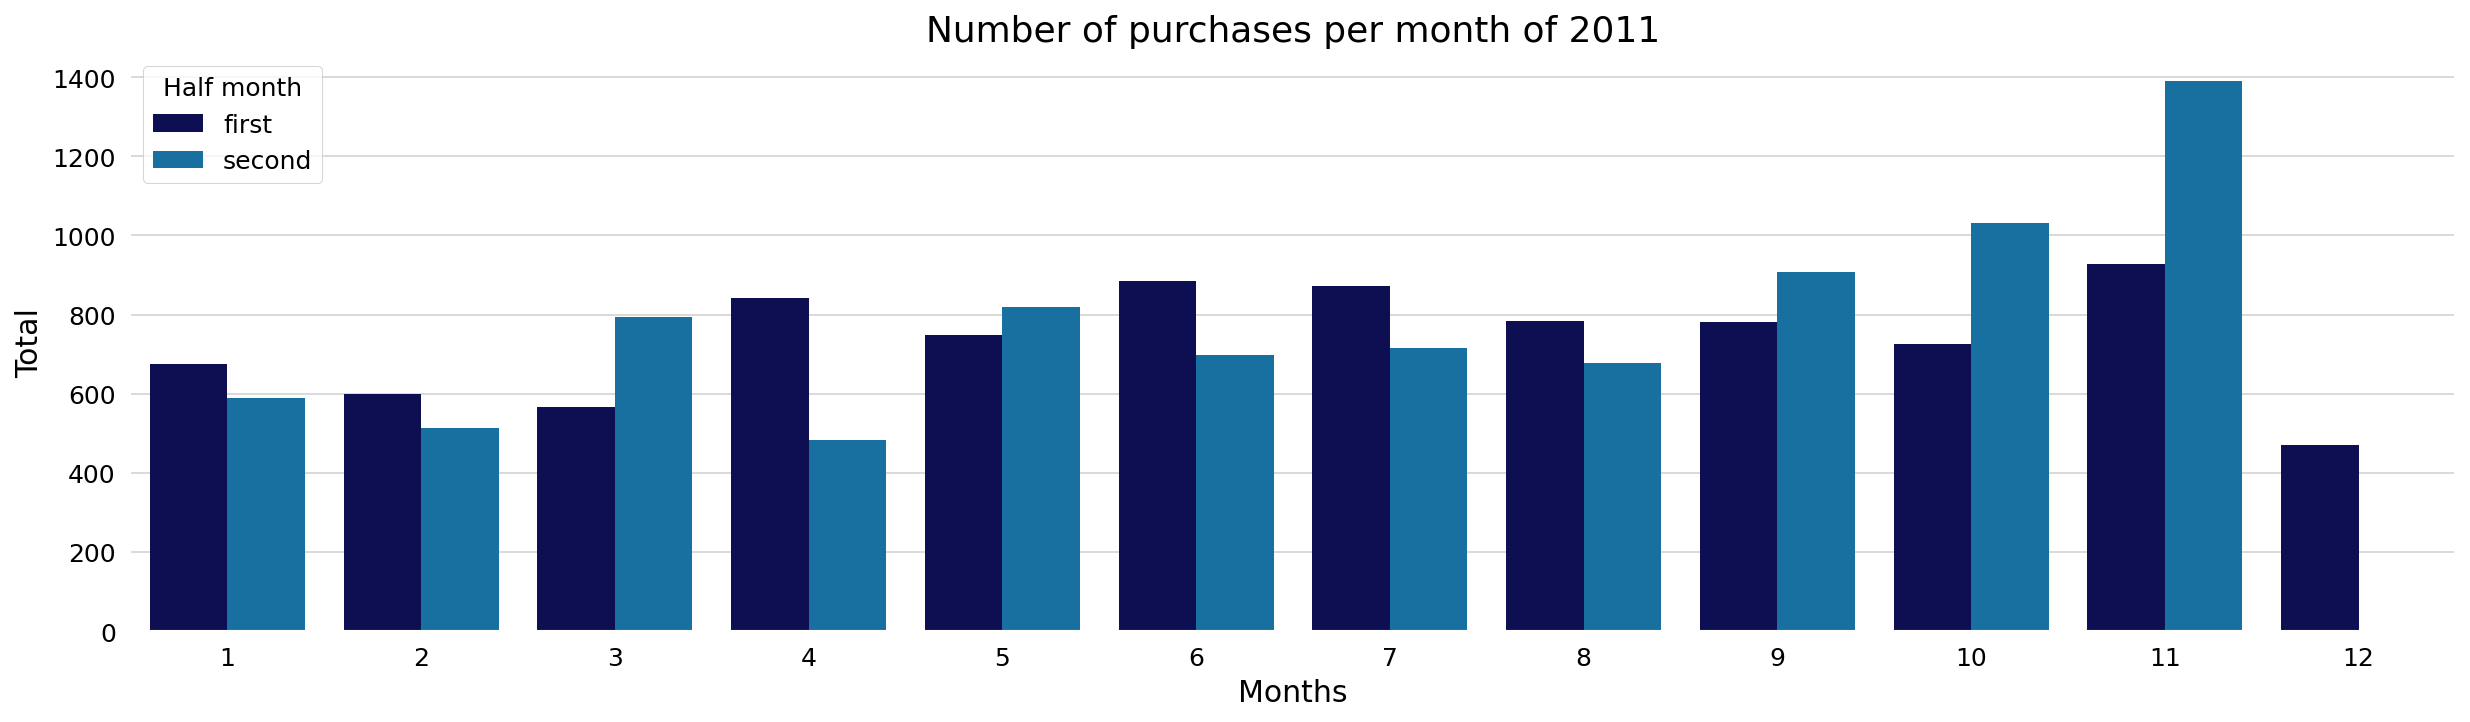

In [30]:
# Data manipulation
df_aux = df1.loc[df1['year'] == 2011, :] # Selecting only 2011 data
df_aux['half_month'] = df_aux['day'].apply(lambda x: 'first' if x <= 15 else 'second') # Creating half month column
df_aux = df_aux[['month', 'bill_no', 'half_month']].groupby(['half_month', 'month']).nunique().reset_index() 

# Creating Figure
fig = sns.barplot(data=df_aux, x='month', y='bill_no', hue='half_month')

# Customizing
fig = set_image(fig, 'Number of purchases per month of 2011', 'Months', 'Total')
fig = plt.legend(title='Half month')

- There is not a clear pattern if the people spend more or less in the first or second half of the month
- People spent more in the first half of the month in January, February and April on the first semester of 2011
- People spent more in the hot summer months like June, July and August on the second semester of 2011
- Then there is an inverse trend for the second half of the month in September, October and November 

### 3.5. Which country has the highest number of purchases? What are the top countries?

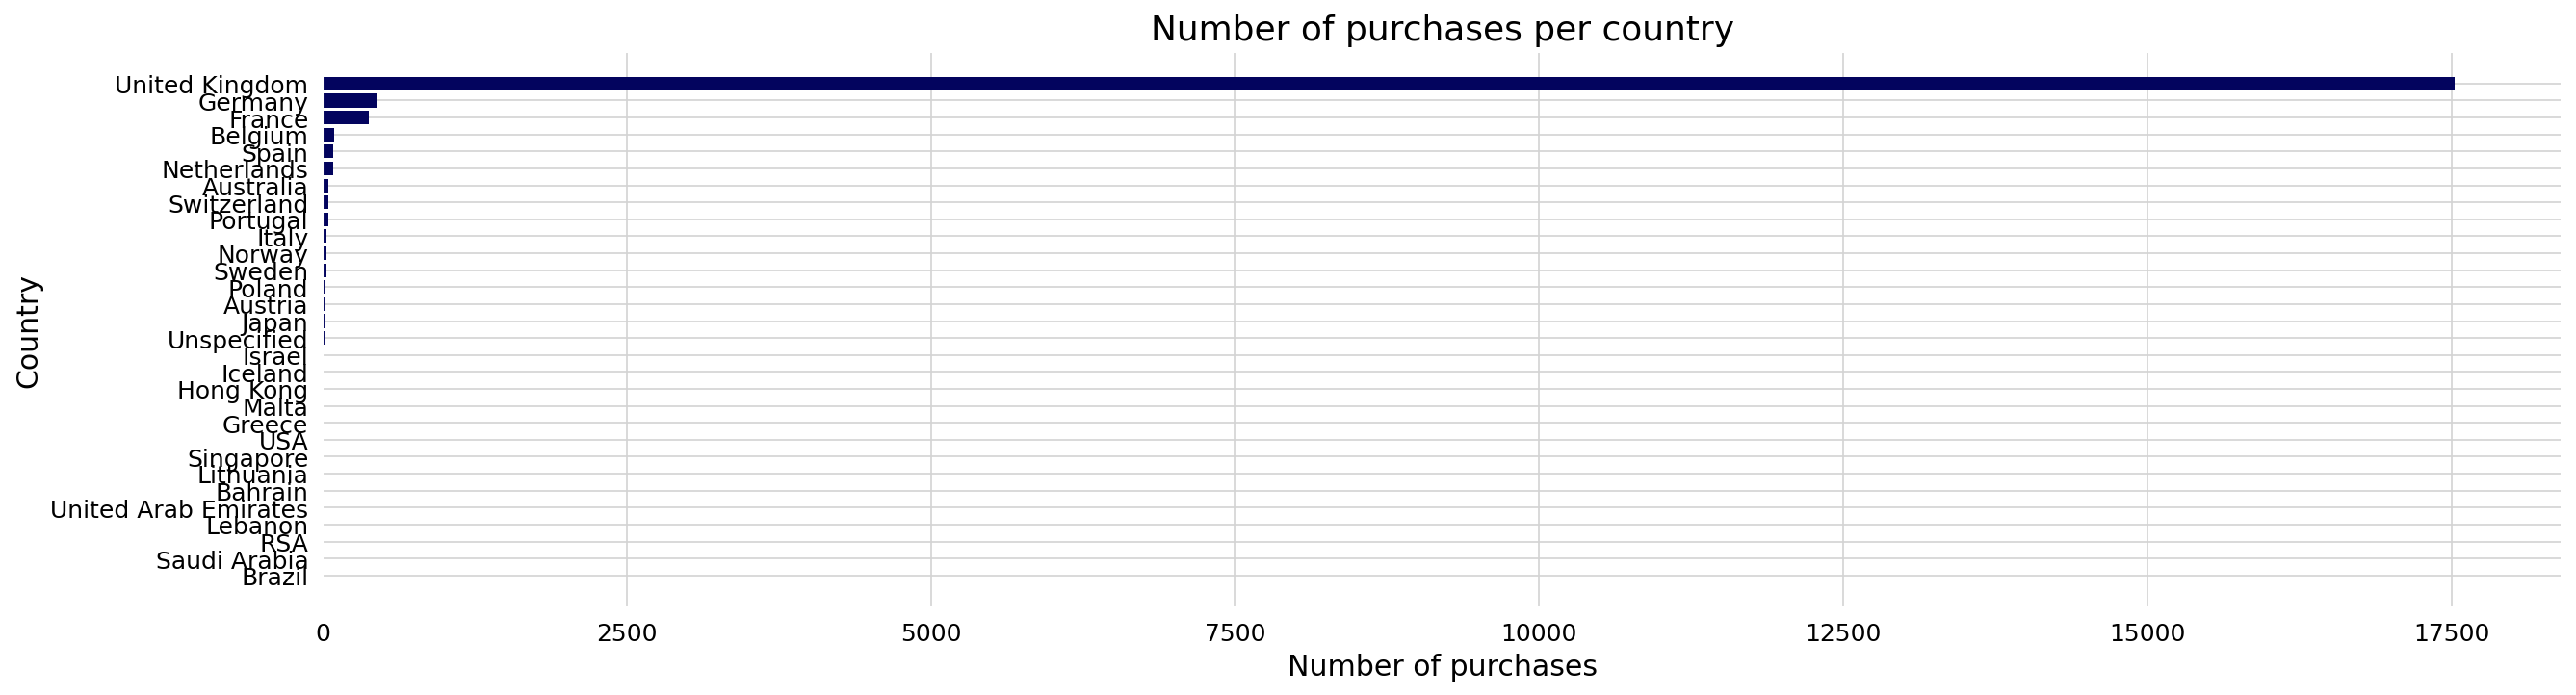

In [31]:
# Data manipulation
df_aux = df1[['bill_no', 'country']].groupby(['country'])['bill_no'].nunique().reset_index()
df_aux = df_aux.sort_values(by='bill_no', ascending=True)

# Creating Figure
fig = plt.barh(df_aux['country'], df_aux['bill_no'])

# Customizing
fig = set_image(fig, 'Number of purchases per country', 'Number of purchases', 'Country')

- The UK is the country with the highest number of purchases by far 

- The top countries are:
1. United Kingdom
2. Germany
3. France
4. Belgium
5. Spain

### 3.6. Who are the clients that spent the most in 2011?

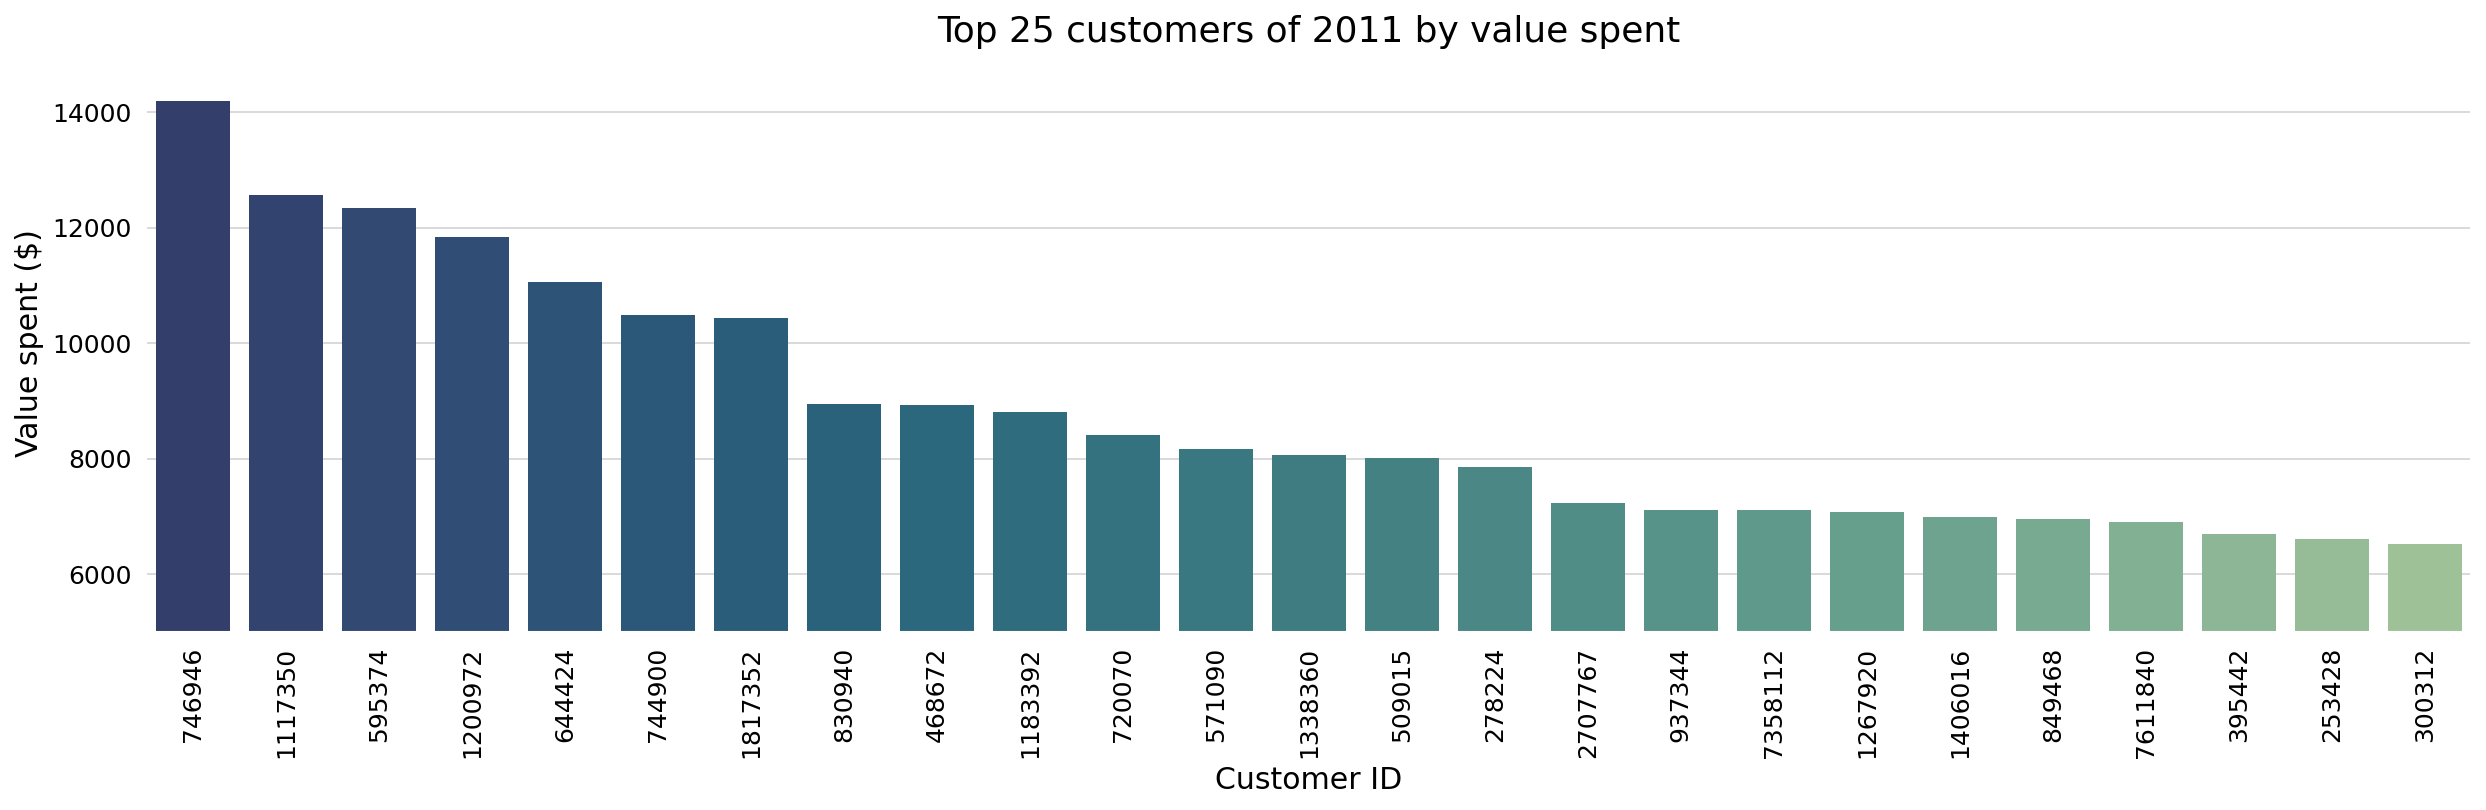

In [32]:
# Data manipulation

# Selecting only 2011 data
df_clients = df1.loc[df1['year'] == 2011, :]
# Calculating the value of each item purchased
df_clients['value'] = df_clients['quantity'] * df_clients['price']
# Grouping by bill_no to get the total value of each purchase
df_clients = df_clients[['bill_no', 'customer_id', 'value']].groupby(['bill_no']).sum().reset_index()
# Grouping by customer_id to get the total value spent by each customer
df_clients = df_clients[['customer_id', 'value']].groupby(['customer_id']).sum().reset_index()
# Sorting by value in descending order
df_clients = df_clients.sort_values(by='value', ascending=False)
# Removing the 'customer_id' 0 - undefined customer
df_clients = df_clients[df_clients['customer_id'] != 0]
# Resetting the index
df_clients.reset_index(drop=True, inplace=True)

# Creating Figure
fig = sns.barplot(data=df_clients[:25], x='customer_id', y='value', order=df_clients[:25]['customer_id'], palette='crest_r')

# Customizing
fig = set_image(fig, 'Top 25 customers of 2011 by value spent', 'Customer ID', 'Value spent ($)', 90)
fig = plt.ylim(5000, 15000)

- The top customer (746946) has spent over **$14,000** in 2011 - that is almost **$2,000** more than the second highest customer
- The 7 top customers spent more than **$10,000** in 2011
- From the 8th to the 14th, the customers are above **$8,000**

### 3.7. What are the top selling items of 2011?

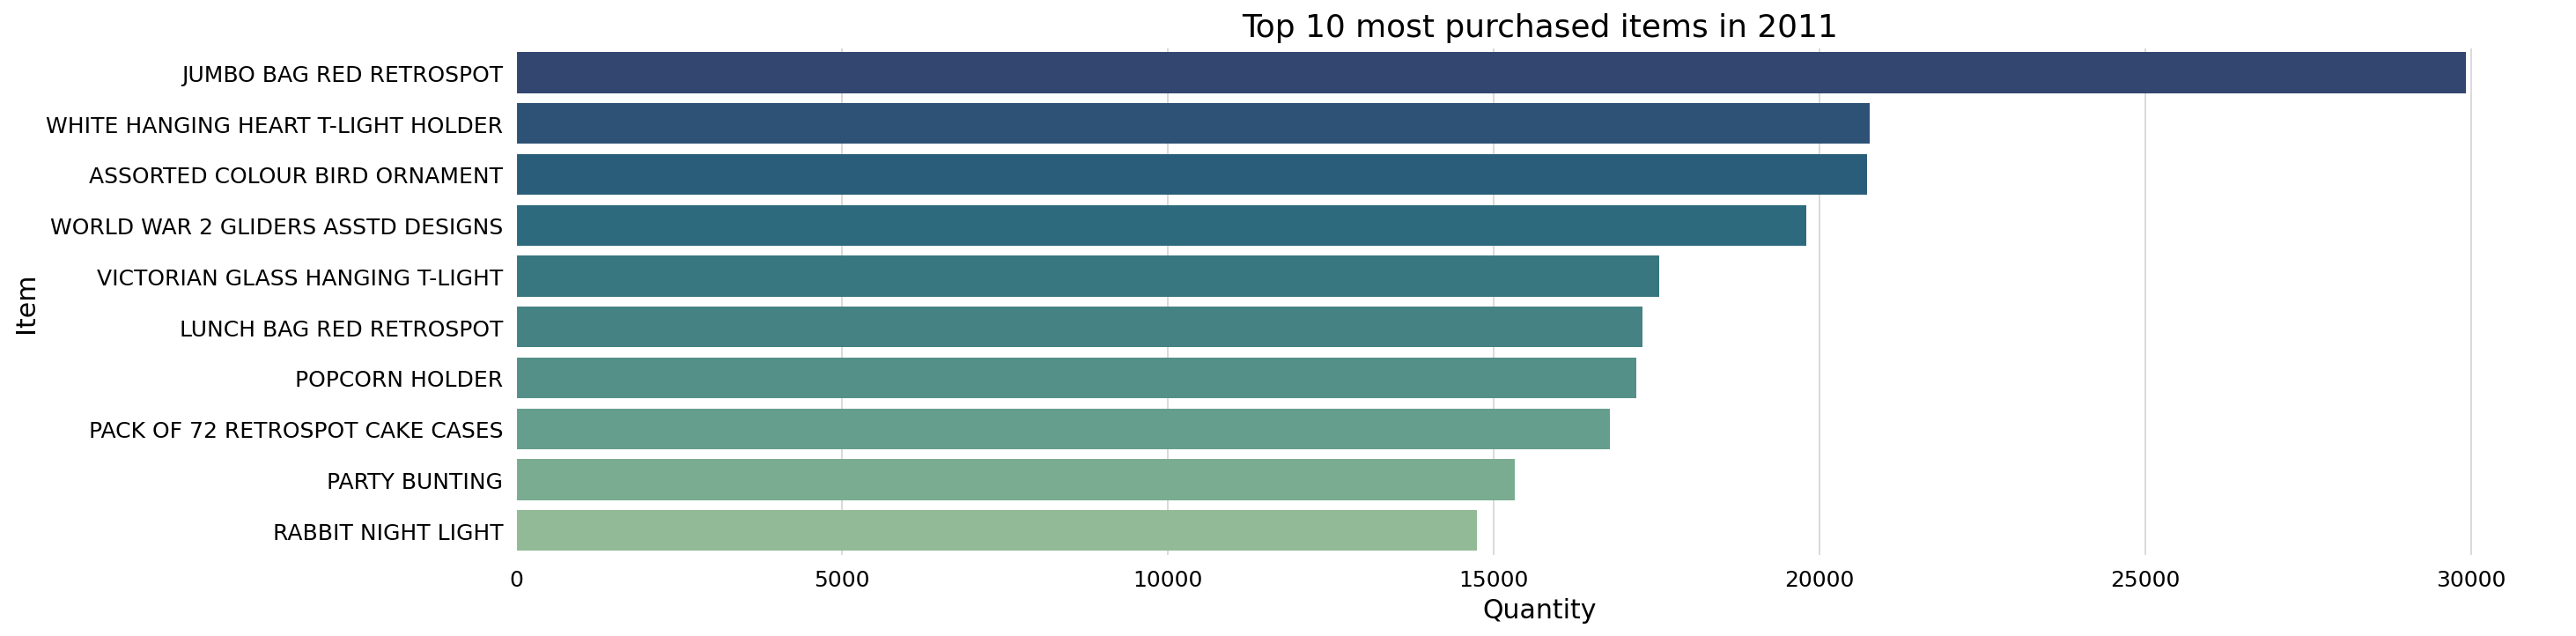

In [33]:
# Data manipulation

# Selecting only 2011 data
df_items = df1.loc[df1['year'] == 2011, :]
# Grouping by item_name
df_items = df_items.groupby(['item_name'])['quantity'].sum().sort_values(ascending=False).reset_index()

# Creating Figure
fig = sns.barplot(data=df_items.head(10), x='quantity', y='item_name', palette='crest_r')

# Customizing 
fig = set_image(fig, 'Top 10 most purchased items in 2011', 'Quantity', 'Item')

### 3.8. What are the average price and average purchased quantity per item? The higher the price, the lower the quantity?

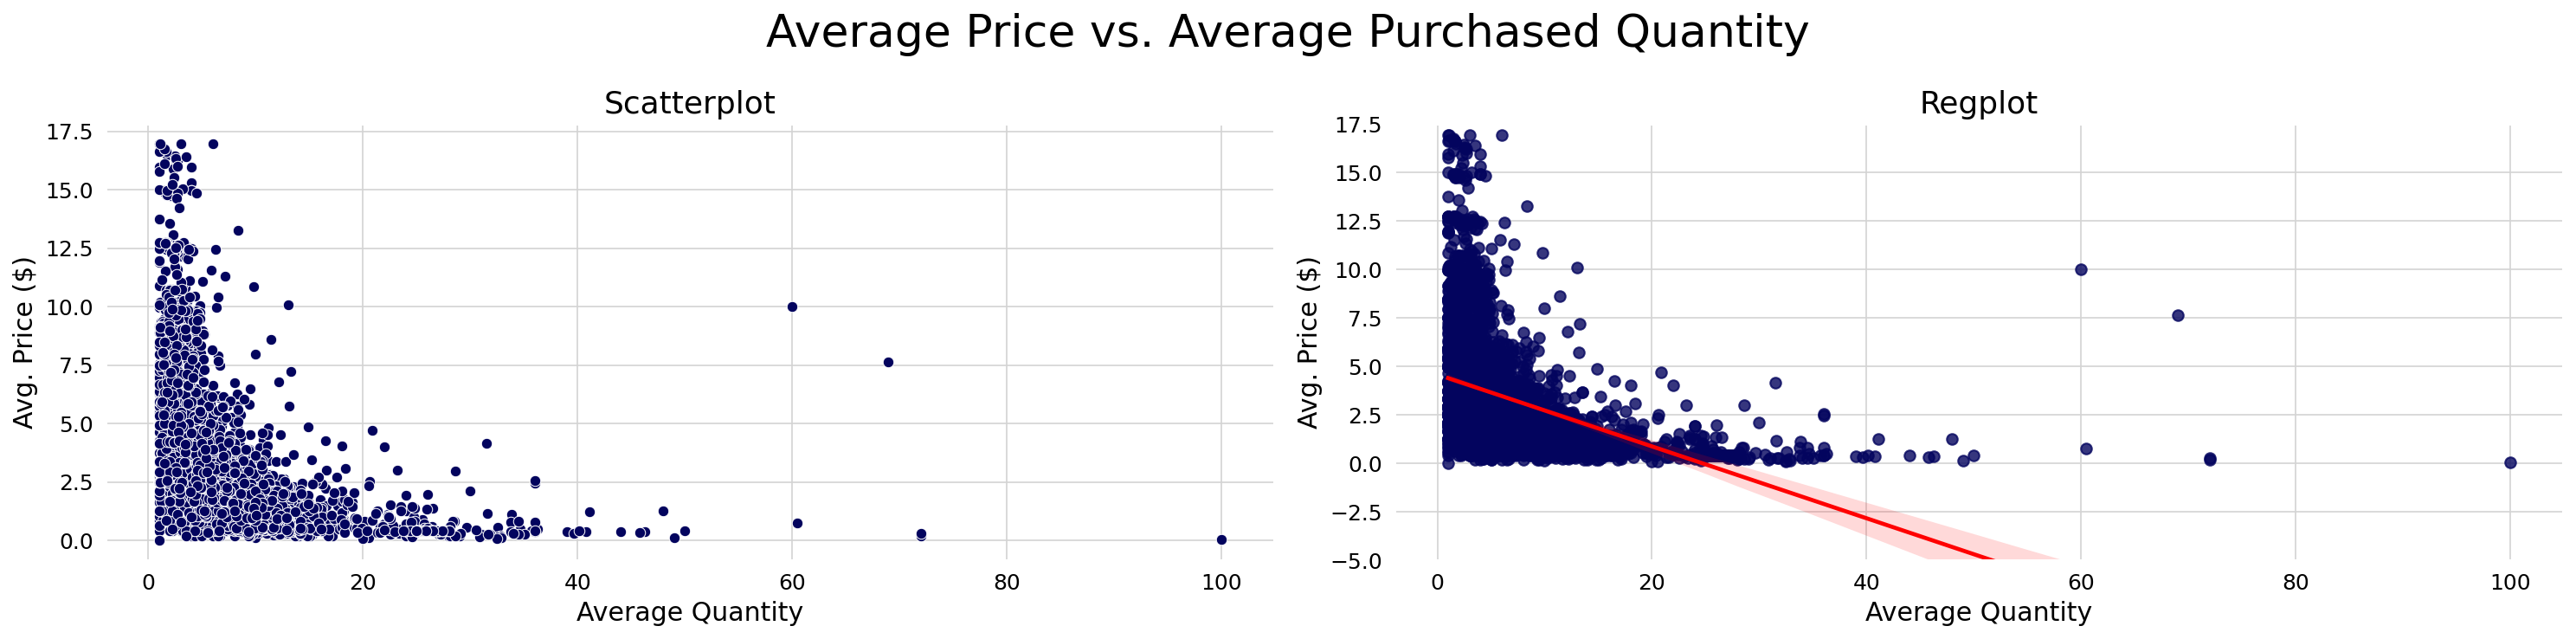

In [34]:
# Data manipulation
df_scatter = df1[['item_name', 'quantity', 'price']].groupby(['item_name']).mean().reset_index()

# Creating Figure
fig, axes = plt.subplots(1, 2)

# Plot 1
plt.subplot(1, 2, 1)
ax1 = sns.scatterplot(data=df_scatter, x='quantity', y='price')
ax1 = set_image(ax1, 'Scatterplot', 'Average Quantity', 'Avg. Price ($)')

# Plot 2
plt.subplot(1, 2, 2)
ax2 = sns.regplot(data=df_scatter, x='quantity', y='price', line_kws={'color': 'red'})
ax2 = plt.ylim(-5, 17.5)
ax2 = set_image(ax2, 'Regplot', 'Average Quantity', 'Avg. Price ($)')

# Main title
fig.suptitle('Average Price vs. Average Purchased Quantity')

# Adjust spacing
plt.tight_layout()

- The relation between price and quantity is inversely proportional
- The average price is higher for items with a lower quantity
- The average price is lower for items with a higher quantity
- So the higher the price, the lower the quantity

### 3.9. What is the distribution of quantity and price in the dataset?

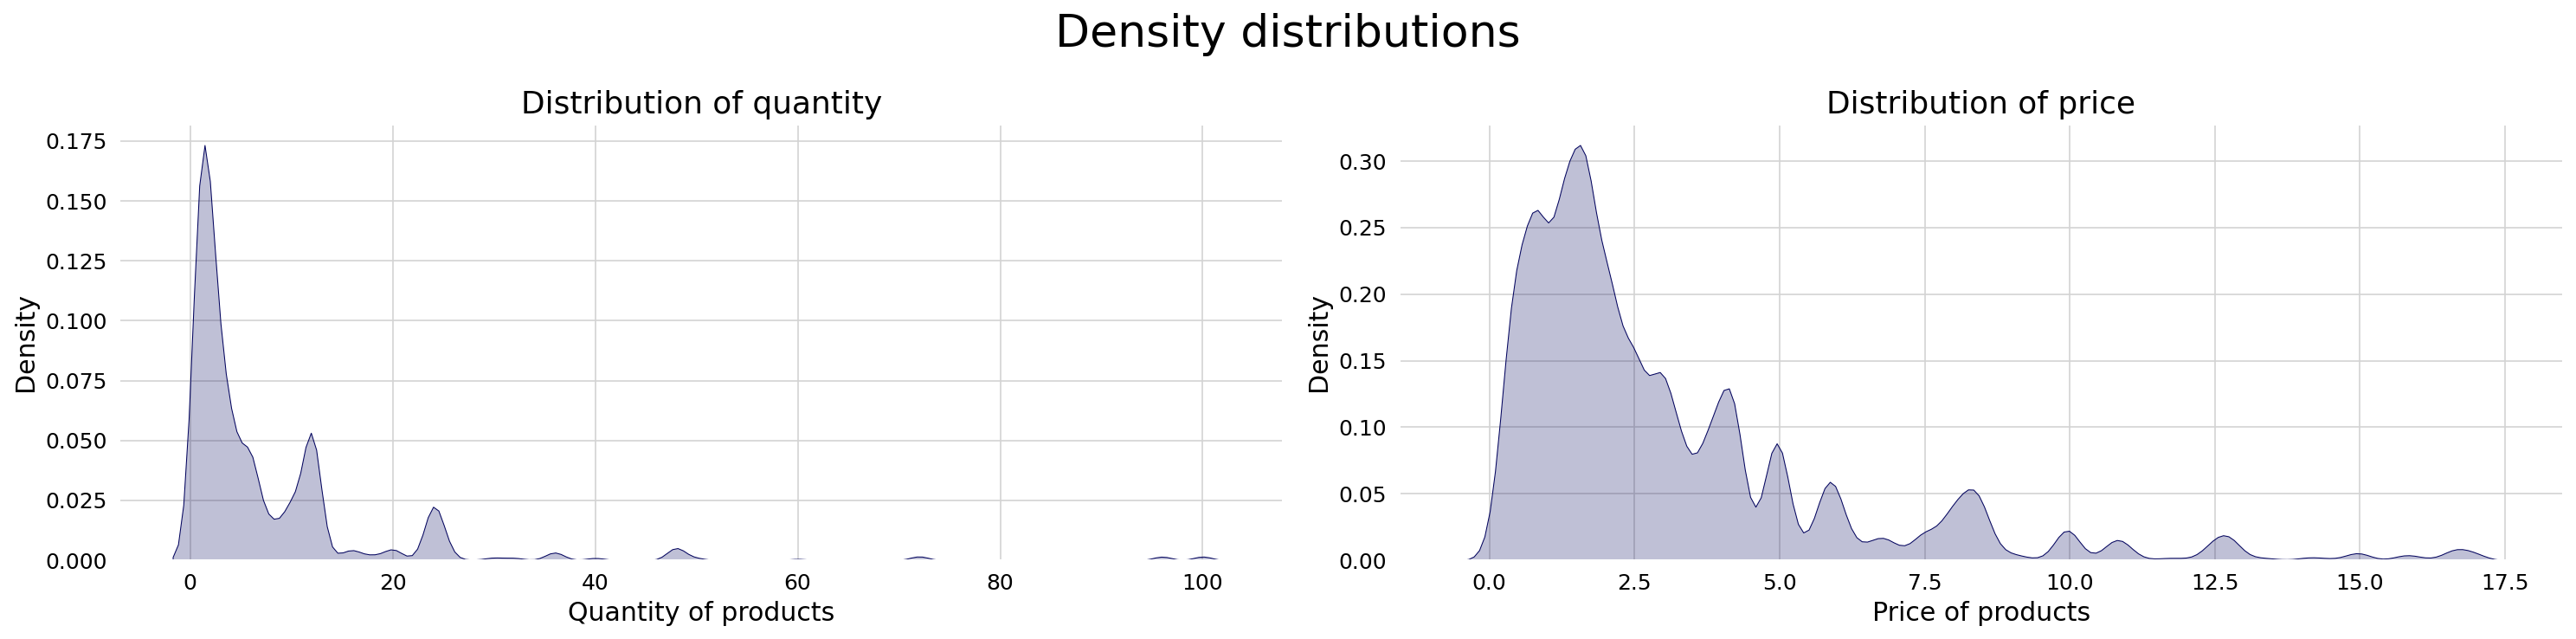

In [35]:
# Creating Figure
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Plot 1
plt.subplot(1, 2, 1)
ax1 = sns.kdeplot(data=df1, x='quantity', fill=True)
ax1 = set_image(ax1, 'Distribution of quantity', 'Quantity of products', 'Density')

# Plot 2
plt.subplot(1, 2, 2)
ax2 = sns.kdeplot(data=df1, x='price', fill=True)
ax2 = set_image(ax2, 'Distribution of price', 'Price of products', 'Density')

# Main title
plt.suptitle('Density distributions')

# Adjusting subplots
plt.tight_layout()

- The great majority of purchases have a quantity between 1 and 10
- The majority of price products are under $3

### 3.10. What is the behavior of *price* and *size* of baskets per month in 2011?

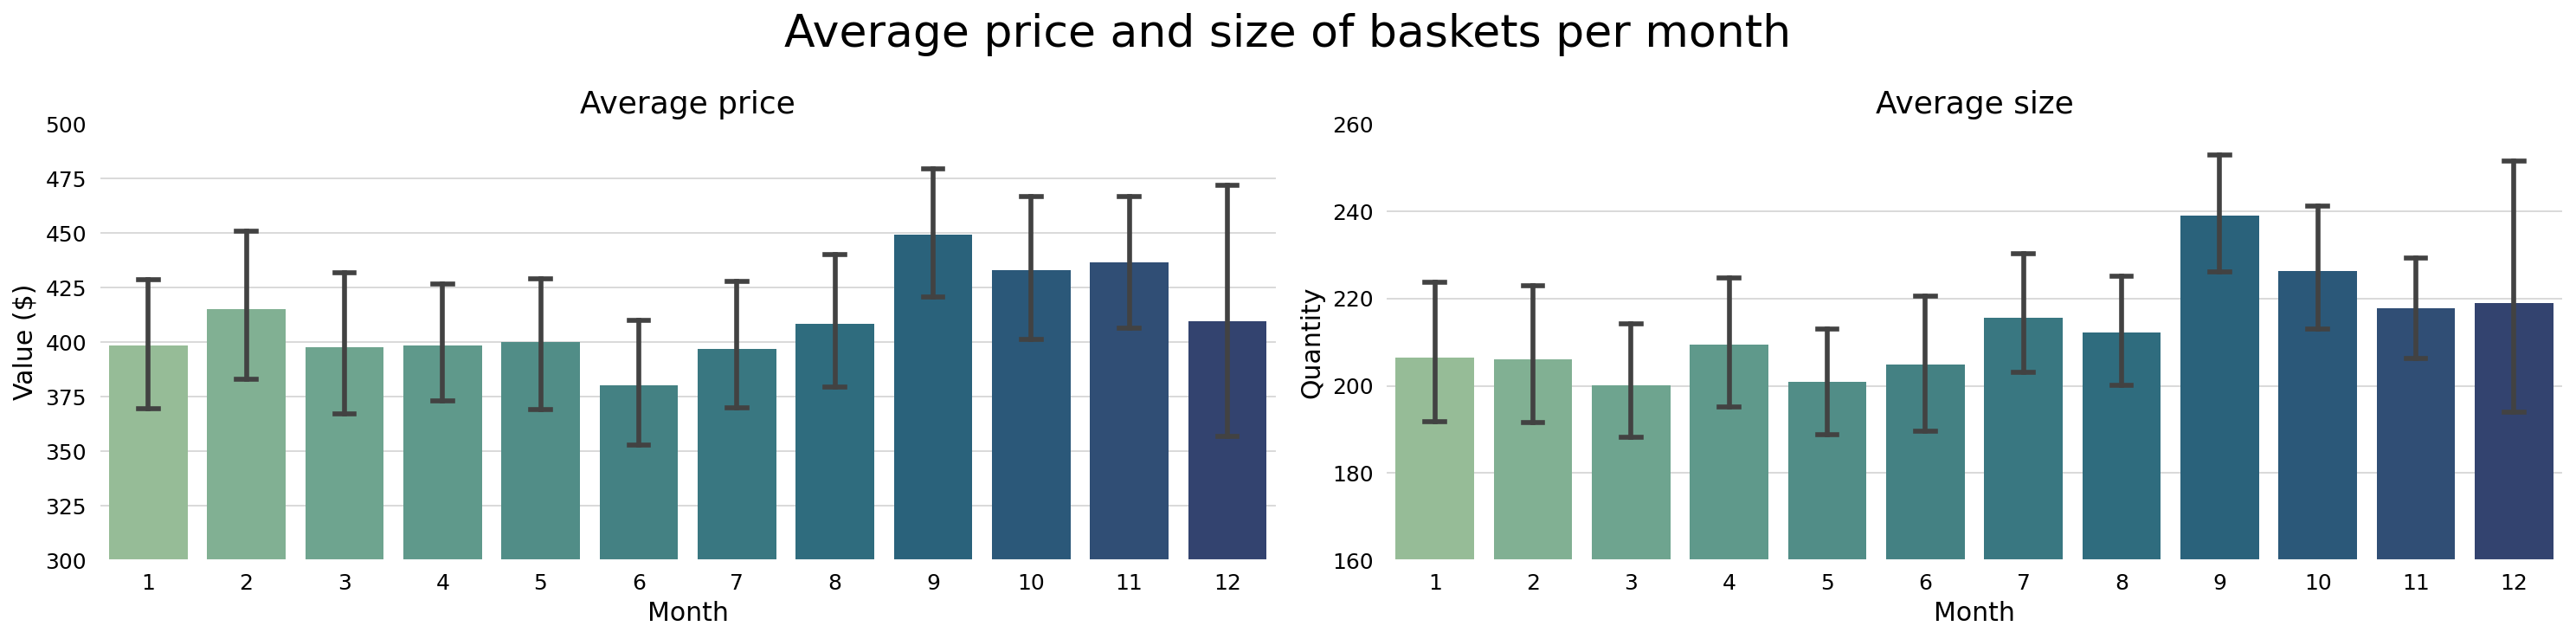

In [36]:
# Data manipulation

# Selecting only 2011 data
df_basket = df1.loc[df1['year'] == 2011, :]
# Calculating the value of each item purchased
df_basket['value'] = df_basket['quantity'] * df_basket['price']
# Grouping by bill_no to get the total value of each purchase
df_basket = df_basket[['bill_no', 'quantity', 'value']].groupby(['bill_no']).sum().reset_index()
# Adding the month of each purchase
df_basket = pd.merge(left=df_basket, right=df1[['bill_no', 'month']].drop_duplicates(), on='bill_no', how='left')

# Creating Figure
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Plot 1: Average price of baskets per month
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=df_basket, x='month', y='value', palette='crest', errorbar=('ci', 95), capsize=.2)
ax1 = set_image(ax1, 'Average price', 'Month', 'Value ($)')
ax1 = plt.ylim(300,500)

# Plot 2: Average size of baskets per month
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=df_basket, x='month', y='quantity', palette='crest', errorbar=('ci', 95), capsize=.2)
ax2 = set_image(ax2, 'Average size', 'Month', 'Quantity')
ax2 = plt.ylim(160,260)

# Main title
plt.suptitle('Average price and size of baskets per month')

# Adjusting subplots
plt.tight_layout()

- The average price of baskets hits the lowest point in June, followed by July
- The highest average price of baskest are seen from September to November
- September and October are also the months with the highest average size os baskets

- **Taking also into account the number of purchases per month seen earlier, we can tell that the end of the year is the best time for the company to sell its products**

## 4. Market Basket Analysis

### 4.1. Data Preparation

In [37]:
# Creating a dataframe with the purchased quantity of each item
item_popularity = df1.groupby('item_name')['quantity'].sum().sort_values(ascending=False)

# Saving a dataframe with the top 150 items
market_basket = df1[df1['item_name'].isin(item_popularity.index[:150].tolist())]
market_basket.head(5)

bill_no                           item_name  quantity        date  price  \
0    536365  WHITE HANGING HEART T-LIGHT HOLDER         6  2010-01-12  2.550   
9    536367       ASSORTED COLOUR BIRD ORNAMENT        32  2010-01-12  1.690   
21   536368            JAM MAKING SET WITH JARS         6  2010-01-12  4.250   
27   536370            ALARM CLOCK BAKELIKE RED        24  2010-01-12  3.750   
28   536370          ALARM CLOCK BAKELIKE GREEN        12  2010-01-12  3.750   

    customer_id         country           timestamp  day  month  year  
0         17850  United Kingdom 2010-01-12 08:26:00   12      1  2010  
9         13047  United Kingdom 2010-01-12 08:34:00   12      1  2010  
21        13047  United Kingdom 2010-01-12 08:34:00   12      1  2010  
27        12583          France 2010-01-12 08:45:00   12      1  2010  
28        12583          France 2010-01-12 08:45:00   12      1  2010

In [38]:
# In order to maintain the dataframe integrity, we will drop the rows with missing values on the 'customer_id' and 'item_name' columns
market_basket.dropna(subset=['customer_id', 'item_name'], inplace=True)

# To decrease the size of the basket, we will work with the data from 2011
market_basket = market_basket[market_basket['year'] == 2011]

# Since the UK is the most popular country in the dataset, we will filter the data for the UK
market_basket = market_basket[market_basket['country'] == 'United Kingdom']

# Dropping unnecessary columns for the analysis
market_basket = market_basket.drop(columns=['date', 'country', 'timestamp', 'day', 'month', 'year']) 

# Resetting the index
market_basket.reset_index(drop=True, inplace=True)

# Displaying
market_basket.head(5)

bill_no                item_name  quantity  price  customer_id
0   539993  JUMBO BAG PINK POLKADOT        10  1.950        13313
1   539993       BLUE POLKADOT WRAP        25  0.420        13313
2   539993       RED RETROSPOT WRAP        25  0.420        13313
3   539993  JUMBO BAG RED RETROSPOT        10  1.950        13313
4   539993   JAM MAKING SET PRINTED        12  1.450        13313

In [39]:
# Number of rows (bills) and columns
df_shape(market_basket)

Number of rows: 75,057
Number of columns: 5


### 4.2. Market Basket Analysis

In [40]:
# Group items by `bill_no` and create a list of items for each bill
basket = market_basket.groupby(['bill_no'])['item_name'].apply(list).reset_index()

# Encode items as binary variables using one-hot encoding
basket_encoded = basket['item_name'].str.join('|').str.get_dummies('|')

# Find frequent itemsets using Apriori algorithm with lower support
frequent_itemsets = apriori(basket_encoded, min_support=0.01, use_colnames=True)

# Generate association rules with lower lift threshold
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# Display association rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='confidence', ascending=False).head(10)

antecedents  \
74   (GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...   
467  (LUNCH BAG WOODLAND, LUNCH BAG PINK POLKADOT, ...   
56   (STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG PINK ...   
415  (LUNCH BAG PINK POLKADOT, LUNCH BAG SPACEBOY D...   
462  (LUNCH BAG WOODLAND, LUNCH BAG PINK POLKADOT, ...   
102  (JUMBO BAG VINTAGE LEAF, JUMBO BAG PINK POLKADOT)   
441  (LUNCH BAG WOODLAND, LUNCH BAG PINK POLKADOT, ...   
86          (JUMBO BAG PEARS, JUMBO BAG RED RETROSPOT)   
99   (JUMBO BAG SCANDINAVIAN BLUE PAISLEY, JUMBO BA...   
13                   (GREEN REGENCY TEACUP AND SAUCER)   

                           consequents  support  confidence   lift  
74   (ROSES REGENCY TEACUP AND SAUCER)    0.019       0.828 16.296  
467          (LUNCH BAG RED RETROSPOT)    0.011       0.826  9.641  
56       (RED RETROSPOT CHARLOTTE BAG)    0.012       0.821 17.765  
415          (LUNCH BAG  BLACK SKULL.)    0.010       0.798 10.523  
462          (LUNCH BAG RED RETROSPOT)    0.011       0.797  9.296  
102          (JUMBO BAG RED RETROSPOT)    0.012       0.796  7.551  
441          (LUNCH BAG RED RETROSPOT)    0.011       0.789  9.203  
86                  (JUMBO BAG APPLES)    0.011       0.788 16.106  
99           (JUMBO BAG RED RETROSPOT)    0.011       0.785  7.447  
13   (ROSES REGENCY TEACUP AND SAUCER)    0.036       0.779 15.334

### Explaining the terms

- **Antecedents:** These are the items that are the starting point for the analysis. In other words, they are present in the basket before the consequent item is purchased.

- **Consequents:** These are the items that are likely to be purchased after the antecedents.

    - Associaton rule: If the *antecedents* are present in the basket, the *consequent* is likely to be purchased.

- **Support:** Support measures how frequently the items of a rule (both antecedents and consequents) appear together in the dataset. It is the proportion of transactions in which the items are bought together. For example, we can see that *"green regency teacup and saucer"* and *"roses regency teacup and saucer"* are bought together 3.6% of the time. Consiering that we are working with 12534 bills, these products were bought together 451 times.

- **Confidence:** This is a measure of the likelihood of the consequent item being purchased when the antecedent item is already in the basket. A high confidence value indicates a strong association between the products. It shows the probability of buying the *consequent* item when the *antecedent* item is already in the basket. 

- **Lift:** Lift measures the degree of association between the antecedent and consequent items, while considering the baseline purchase probability of the consequent item. A lift value greater than 1 indicates a positive association, meaning that the items are more likely to be bought together than independently. A value less than 1 indicates a negative association. 

### Table results
- Sorting the results by confidence, we can see that if the customer already have *regency cakestand 3 tier, green regency...* in the basket, there is a confidence of 83% that *roses regency teacup and saucer* will be purchased as the consequent item.

***

## 5. Recommendation System for clients

### Steps

1. Construct an utility matrix
- Utility matrix is a matrix that contains the number of times an item was purchased (`quantity`) by each client
2. Calculate the similarity between clients using *cosine similarity*
- Cosine similarity is a metric that measures the similarity between two vectors
3. Create a dataframe that contains the similarity matrix
- Clients as rows and columns with their similarity values in the matrix
4. Generate recommendations looping through each client 
- The goal is to recommend two products based on the three most similar clients
- Get the k most similar clients
- Get the products purchased by the similar clients
- We want only the products that have not been purchased
- Recommend the top n products that have not been purchased
5. Create a dataframe with the recommendations for each client

### 5.1. Construct an utility matrix

In [41]:
# Create the utility matrix
utility_matrix  = df1.pivot_table(
    index       = 'customer_id',    # each row is a customer
    columns     = 'item_name',      # each column is an item
    values      = 'quantity',       # the values are the quantity of items purchased
    fill_value  = 0                 # if there is no item purchased, the value is 0
)

# Display the utility matrix
utility_matrix.head(5)

item_name    10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
customer_id                                                       
12347                         0.000                       0.000   
12349                         0.000                       0.000   
12350                         0.000                       0.000   
12352                         0.000                       0.000   
12353                         0.000                       0.000   

item_name    12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
customer_id                                                         
12347                            0.000                      0.000   
12349                            0.000                      0.000   
12350                            0.000                      0.000   
12352                            0.000                      0.000   
12353                            0.000                      0.000   

item_name    12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
customer_id                                                                   
12347                               0.000                             0.000   
12349                               0.000                             0.000   
12350                               0.000                             0.000   
12352                               0.000                             0.000   
12353                               0.000                             0.000   

item_name    12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
customer_id                                                                   
12347                                  0.000                          0.000   
12349                                  0.000                          0.000   
12350                                  0.000                          0.000   
12352                                  0.000                          0.000   
12353                                  0.000                          0.000   

item_name    12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
customer_id                                                                     
12347                                      0.000                        0.000   
12349                                      0.000                        0.000   
12350                                      0.000                        0.000   
12352                                      0.000                        0.000   
12353                                      0.000                        0.000   

item_name    12 PENCILS TALL TUBE POSY  12 PENCILS TALL TUBE RED RETROSPOT  \
customer_id                                                                  
12347                            0.000                               0.000   
12349                            0.000                               0.000   
12350                            0.000                               0.000   
12352                            0.000                               0.000   
12353                            0.000                               0.000   

item_name    12 PENCILS TALL TUBE SKULLS  12 PENCILS TALL TUBE WOODLAND  \
customer_id                                                               
12347                              0.000                          0.000   
12349                              0.000                          0.000   
12350                              0.000                          0.000   
12352                              0.000                          0.000   
12353                              0.000                          0.000   

item_name    12 PINK HEN+CHICKS IN BASKET  12 PINK ROSE PEG PLACE SETTINGS  \
customer_id                                                                  
12347                               0.000                            0.000   
12349                               0.000                      

In [42]:
# Display the number of rows (clients) and columns (items)
df_shape(utility_matrix)

Number of rows: 4,253
Number of columns: 3,813


### 5.2. Calculate the similarity matrix

In [43]:
# Create the similarity matrix using cosine similarity on the utility matrix
similarity_matrix = cosine_similarity(utility_matrix)

# Display the similarity matrix array
similarity_matrix

array([[1.        , 0.0281322 , 0.04015851, ..., 0.01519015, 0.07360037,
        0.        ],
       [0.0281322 , 1.        , 0.02992193, ..., 0.01339902, 0.06875692,
        0.00802274],
       [0.04015851, 0.02992193, 1.        , ..., 0.        , 0.03381046,
        0.        ],
       ...,
       [0.01519015, 0.01339902, 0.        , ..., 1.        , 0.01148988,
        0.        ],
       [0.07360037, 0.06875692, 0.03381046, ..., 0.01148988, 1.        ,
        0.10103257],
       [0.        , 0.00802274, 0.        , ..., 0.        , 0.10103257,
        1.        ]])

### 5.3. Create a dataframe that contains the similarity matrix

In [44]:
# Transforming the array into a dataframe
similarity  = pd.DataFrame(
    data    = similarity_matrix,    # the array we want to transform
    index   = utility_matrix.index, # clients as rows
    columns = utility_matrix.index  # clients as columns
)

# Display the similarity dataframe
similarity.head(5)

customer_id  12347  12349  12350  12352  12353  12354  12355  12356  12357  \
customer_id                                                                  
12347        1.000  0.028  0.040  0.024  0.000  0.013  0.013  0.053  0.020   
12349        0.028  1.000  0.030  0.077  0.000  0.005  0.000  0.207  0.104   
12350        0.040  0.030  1.000  0.000  0.000  0.000  0.000  0.000  0.075   
12352        0.024  0.077  0.000  1.000  0.000  0.059  0.001  0.059  0.053   
12353        0.000  0.000  0.000  0.000  1.000  0.000  0.006  0.045  0.058   

customer_id  12358  12360  12361  12362  12363  12364  12370  12371  12373  \
customer_id                                                                  
12347        0.000  0.095  0.000  0.106  0.128  0.085  0.000  0.001  0.024   
12349        0.043  0.087  0.062  0.085  0.017  0.103  0.000  0.000  0.038   
12350        0.000  0.051  0.000  0.076  0.000  0.018  0.000  0.000  0.000   
12352        0.162  0.023  0.073  0.040  0.000  0.007  0.000  0.002  0.000   
12353        0.007  0.000  0.000  0.000  0.000  0.000  0.377  0.000  0.000   

customer_id  12374  12377  12378  12379  12380  12381  12383  12384  12386  \
customer_id                                                                  
12347        0.074  0.038  0.035  0.003  0.165  0.297  0.098  0.088  0.000   
12349        0.032  0.030  0.047  0.068  0.022  0.027  0.043  0.049  0.056   
12350        0.000  0.075  0.000  0.036  0.000  0.000  0.016  0.000  0.026   
12352        0.001  0.047  0.029  0.000  0.030  0.145  0.017  0.012  0.000   
12353        0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

customer_id  12388  12390  12393  12394  12395  12397  12398  12399  12401  \
customer_id                                                                  
12347        0.016  0.113  0.073  0.000  0.163  0.157  0.153  0.208  0.010   
12349        0.075  0.050  0.021  0.106  0.020  0.057  0.094  0.039  0.004   
12350        0.000  0.035  0.054  0.132  0.037  0.021  0.017  0.038  0.000   
12352        0.014  0.002  0.045  0.054  0.063  0.122  0.058  0.018  0.014   
12353        0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

customer_id  12402  12407  12408  12409  12410  12413  12414  12415  12417  \
customer_id                                                                  
12347        0.009  0.119  0.079  0.051  0.001  0.000  0.000  0.095  0.078   
12349        0.025  0.029  0.038  0.066  0.000  0.077  0.033  0.096  0.114   
12350        0.000  0.000  0.062  0.043  0.000  0.000  0.061  0.052  0.000   
12352        0.075  0.076  0.046  0.034  0.005  0.013  0.000  0.084  0.040   
12353        0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

customer_id  12418  12421  12422  12423  12424  12425  12426  12427  12429  \
customer_id                                                                  
12347        0.015  0.060  0.000  0.053  0.010  0.040  0.005  0.098  0.001   
12349        0.001  0.000  0.006  0.017  0.014  0.043  0.076  0.008  0.007   
12350        0.000  0.000  0.000  0.022  0.000  0.026  0.052  0.000  0.000   
12352        0.014  0.112  0.000  0.019  0.032  0.005  0.001  0.008  0.040   
12353        0.000  0.081  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

customer_id  12430  12431  12432  12433  12434  12436  12437  12438  12441  \
customer_id                                                                  
12347        0.017  0.216  0.046  0.076  0.004  0.268  0.169  0.028  0.000   
12349        0.000  0.048  0.129  0.102  0.095  0.003  0.055  0.074  0.000   
12350        0.000  0.018  0.000  0.066  0.000  0.000  0.015  0.080  0.000   
12352        0.000  0.088  0.075  0.086  0.002  0.033  0.031  0.085  0.005   
12353        0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

customer_id  12442  12444  12445  12446  12447  12448  12449  12450  12451  \
customer_id                                                                  
12347        0.

### 5.4. Generate recommendations

In [45]:
# Generating the recommendations

# Settings
k = 3           # Number of similar clients
n_recomm = 2    # Number of recommendations
recomm = {}     # Dictionary to store recommendations

# Loop through each client
for client in similarity.index:
    
    # Get the k most similar clients
    similar_clients = similarity.loc[client].nlargest(k+1).iloc[1:].index
    
    # Get the products purchased by the similar clients
    products_purchased = utility_matrix.loc[similar_clients].sum(axis=0)
    
    # We want only the products that have not been purchased
    products_not_purchased = utility_matrix.loc[client] == 0

    # Recommend the top n products that have not been purchased
    products_recommended = products_purchased[products_not_purchased].nlargest(n_recomm).index

    # Store the recommendations
    recomm[client] = products_recommended

# Display the recommendations
recomm

{12347: Index(['WRAP 50'S  CHRISTMAS', '10 COLOUR SPACEBOY PEN'], dtype='object', name='item_name'),
 12349: Index(['GIRLS VINTAGE TIN SEASIDE BUCKET', 'RED RETROSPOT WRAP'], dtype='object', name='item_name'),
 12350: Index(['BLACK STITCHED WALL CLOCK', 'PACK OF 12 LONDON TISSUES'], dtype='object', name='item_name'),
 12352: Index(['WALL TIDY RETROSPOT', 'CERAMIC BOWL WITH LOVE HEART DESIGN'], dtype='object', name='item_name'),
 12353: Index(['HANGING HEART MIRROR DECORATION', 'MINI CAKE STAND T-LIGHT HOLDER'], dtype='object', name='item_name'),
 12354: Index(['JUMBO BAG PINK VINTAGE PAISLEY', 'JUMBO BAG RED RETROSPOT'], dtype='object', name='item_name'),
 12355: Index(['WHITE SAGE INCENSE', 'COLOURED GLASS STAR T-LIGHT HOLDER'], dtype='object', name='item_name'),
 12356: Index(['STRAWBERRY CERAMIC TRINKET POT', 'SET 20 NAPKINS FAIRY CAKES DESIGN'], dtype='object', name='item_name'),
 12357: Index(['HAND WARMER BIRD DESIGN', 'PLASTERS IN TIN VINTAGE PAISLEY'], dtype='object', name='ite

### 5.5. Create a dataframe with the recommendations for each client

In [46]:
# Transforming the dictionary into a dataframe

# Initialize lists to store data
customer_ids = []
product_1    = []
product_2    = []

# Iterating through the dictionary
for customer_id, products in recomm.items():
    
    # Append data to lists
    customer_ids.append(customer_id)
    product_1.append(products[0])
    product_2.append(products[1])

# Create DataFrame
df_recommendations = pd.DataFrame({
    'customer_id':  customer_ids,
    'product_1':    product_1, 
    'product_2':    product_2
})

# Display the dataframe
df_recommendations.head(15)

customer_id                         product_1  \
0         12347              WRAP 50'S  CHRISTMAS   
1         12349  GIRLS VINTAGE TIN SEASIDE BUCKET   
2         12350         BLACK STITCHED WALL CLOCK   
3         12352               WALL TIDY RETROSPOT   
4         12353   HANGING HEART MIRROR DECORATION   
5         12354    JUMBO BAG PINK VINTAGE PAISLEY   
6         12355                WHITE SAGE INCENSE   
7         12356    STRAWBERRY CERAMIC TRINKET POT   
8         12357           HAND WARMER BIRD DESIGN   
9         12358      BLACK/BLUE POLKADOT UMBRELLA   
10        12360     GINGERBREAD MAN COOKIE CUTTER   
11        12361           LUNCH BOX I LOVE LONDON   
12        12362                SPACEBOY GIFT WRAP   
13        12363                RED RETROSPOT TAPE   
14        12364      MAGIC DRAWING SLATE SPACEBOY   

                              product_2  
0                10 COLOUR SPACEBOY PEN  
1                    RED RETROSPOT WRAP  
2             PACK OF 12 LONDON TISSUES  
3   CERAMIC BOWL WITH LOVE HEART DESIGN  
4        MINI CAKE STAND T-LIGHT HOLDER  
5               JUMBO BAG RED RETROSPOT  
6    COLOURED GLASS STAR T-LIGHT HOLDER  
7     SET 20 NAPKINS FAIRY CAKES DESIGN  
8       PLASTERS IN TIN VINTAGE PAISLEY  
9                RED RETROSPOT UMBRELLA  
10          CHILDREN'S APRON DOLLY GIRL  
11              LUNCH BAG PINK POLKADOT  
12   FOLKART STAR CHRISTMAS DECORATIONS  
13  SET 40 HEART SHAPE PETIT FOUR CASES  
14           BIRTHDAY BANQUET GIFT WRAP

#### 5.5.1. Function to generate recommendations

In [47]:
def recsys(customer_id):
    print('First product recommended: {}'.format(df_recommendations.loc[df_recommendations['customer_id'] == customer_id].values[0][1]))
    print('Second product recommended: {}'.format(df_recommendations.loc[df_recommendations['customer_id'] == customer_id].values[0][2]))

In [48]:
recsys(18283)

First product recommended: POLKADOT PEN
Second product recommended: WORLD WAR 2 GLIDERS ASSTD DESIGNS


***